# 0.Introduction

## 0.1 Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from pandas import DataFrame
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import warnings
from sklearn import linear_model
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from keras.utils.vis_utils import plot_model
from tensorflow import keras
from sklearn.svm import SVR
import datetime
import seaborn as sns
from os import listdir
from os.path import isfile, join
from sklearn.preprocessing import StandardScaler, MinMaxScaler,FunctionTransformer, PowerTransformer, QuantileTransformer, RobustScaler
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import activations
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from IPython.display import display_html 
from re import VERBOSE
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from pyparsing.helpers import disable_diag
from scipy.stats.mstats import winsorize

warnings.filterwarnings("ignore", category= RuntimeWarning)
warnings.filterwarnings("ignore", category= FutureWarning)
set_config(display="diagram")

## 0.2 Variables

In [ ]:
#dataframe to save various results
results_mse = pd.DataFrame(columns=['modelName', 'train_mse', 'test_mse', 'difference'])
results_mae = pd.DataFrame(columns=['modelName', 'train_mae', 'test_mae', 'difference'])
results_r2score = pd.DataFrame(columns=['modelName', 'train_r2score', 'test_r2score', 'difference'])
results_evs = pd.DataFrame(columns=['modelName', 'train_evs', 'test_evs', 'difference'])

## 0.3 Functions

### -data preparation

In [ ]:
#checks missing data in %-tage in given dataset
def checkDataForNulls (dataset):
    percent_missing = dataset.isnull().sum() * 100 / len(dataset)
    missing_value_df = pd.DataFrame({'Column': dataset.columns,
                                 'percent_missing': percent_missing})
    print(missing_value_df)

In [ ]:
#show boxplot for dataset befroe modifications and after
def boxplot_compare_dist(df, y_before, y_after):
    f = plt.figure(figsize=(16,8))
    st = f.suptitle(f"{y_before} comparison", fontsize="x-large")
    ax1=plt.subplot(2,2,1)
    a = sns.distplot(df[y_before])
    plt.subplot(2,2,3)
    sns.boxplot(y=y_before, data = df)
    ax2=plt.subplot(2,2,2)
    b = sns.distplot(df [y_after])
    plt.subplot(2,2,4)
    sns.boxplot(y=y_after, data = df)
    a.title.set_text('before')
    b.title.set_text('after')
    plt.show()

In [ ]:
#transform specific column with requested tranfromer
def transform (transf, X_train, X_test, name, col):
  #train
  X_train_df = pd.DataFrame(X_train, columns = ['AT','V', 'AP', "RH"])
  X_train_df = X_train_df.drop(['AT','V'], axis=1)
  data_trans = transf.fit_transform(X_train_df) 
  data_trans_df = pd.DataFrame(data_trans, columns = ['AP', "RH"])

  #test
  X_test_df = pd.DataFrame(X_test, columns = ['AT','V', 'AP', "RH"])
  X_test_df = X_test_df.drop(['AT','V'], axis=1)
  data_trans_test = transf.transform(X_test_df)
  data_trans_test_df = pd.DataFrame(data_trans_test, columns = ['AP', "RH"])

  #show results
  compare_to_normal (X_train_df,data_trans_df, col, f'{name}_Train')
  compare_to_normal (X_test_df,data_trans_test_df, col, f'{name}_Test')
  return data_trans, data_trans_test

In [ ]:
#iterate over list of transformers and check specific column
def transform_list(X_train, X_test, col):
    rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
    sqr_transformer = FunctionTransformer(lambda x: x ** (1 / 2), validate = True)
    exp_transformer = FunctionTransformer(lambda x: x **( 1 * 1.2), validate = True)
    yj_transformer = PowerTransformer(method = 'yeo-johnson', standardize = False)
    bc_transformer = PowerTransformer(method = 'box-cox', standardize = False)
    transformer_list=[rcpr_transformer,sqr_transformer, exp_transformer, yj_transformer, bc_transformer ]
    transformer_names = ["rcpr_transformer","sqr_transformer", "exp_transformer", "yj_transformer", "bc_transformer" ]
    for j in range(0, len(transformer_list)):
         transform(transformer_list[j] ,X_train, X_test, transformer_names[j], col) 

In [ ]:
def transform_y (y_train,y_test):
  y_target = y_train.to_numpy()
  y_tr_test = y_test.to_numpy()

  y_data = y_target.reshape(len(y_target), 1)
  y_data_test = y_tr_test.reshape(len(y_tr_test), 1)

  # QuantileTransformer to make bimodel to uniform
  quant_trans = QuantileTransformer(n_quantiles=300, output_distribution='uniform')

  y_trans = quant_trans.fit_transform(y_data)
  y_trans_test = quant_trans.transform(y_data_test)
  return y_target, y_trans,  y_tr_test, y_trans_test

In [ ]:
#plot specific column before modification and after modification in comparison to normal destribution
def compare_to_normal (df_before,df_after, col, name):
    f = plt.figure(figsize = (50, 10))
    st = f.suptitle(f"{col}_{name}", fontsize=30)
    plt.subplot(1, 4, 1)
    data = df_before[col]
    ax = sns.histplot(x=data, stat="density")
    mean = data.mean()
    std = data.std()
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = stats.norm.pdf(x, mean, std)
    plt.plot(x, p, color="black", linewidth=2)
    plt.xlabel(f'{col} before transformation', fontsize=20)
    plt.subplot(1, 4, 2)
    stats.probplot(df_before[col], dist = 'norm', plot = plt)
    plt.xlabel(f'{col} before transformation', fontsize=20)
    plt.subplot(1, 4, 3)
    data = df_after[col]
    ax = sns.histplot(x=data, stat="density")
    mean = data.mean()
    std = data.std()
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = stats.norm.pdf(x, mean, std)
    plt.plot(x, p, color="black", linewidth=2)
    plt.xlabel(f'{col} after transformation', fontsize=20)
    plt.subplot(1, 4, 4)
    stats.probplot(df_after[col], dist = 'norm', plot = plt)
    plt.xlabel(f'{col} after transformation', fontsize=20)
    plt.show()

In [ ]:
#split and impute dataset
def reset_t_t_split(df, imputer):
  X = df.iloc[:, :-1].values
  y= df.iloc[:, -1].values
  #split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
  #impute
  X_train_i = imputer.fit_transform(X_train)
  X_test_i = imputer.transform(X_test)
  return X_train_i, X_test_i, y_train, y_test

In [ ]:
# scale only
def scale (scaler, X_train_i, X_test_i, y_train, y_test ):
  #scale
  sc_x=scaler
  sc_y=scaler
  y_train_r = y_train.reshape(len(y_train), 1)
  y_test_r = y_test.reshape(len(y_test), 1)
  X_train_sc = sc_x.fit_transform(X_train_i)
  X_test_sc = sc_x.transform(X_test_i)
  y_train_sc = sc_y.fit_transform(y_train_r)
  y_test_sc = sc_y.transform(y_test_r)
  
  return  X_train_sc, X_test_sc, y_train_sc, y_test_sc, sc_y, y_test, y_train

In [ ]:
def transform_scale_RH (RH_transformer, df, scaler):
  X_train_o, X_test_o, y_train, y_test = reset_t_t_split(df, KNNImputer(n_neighbors=2))
  #train and test numpy array with transfromed RH col
 
  RH_train, RH_test = transform(RH_transformer,X_train_o, X_test_o, 'final_transform_box_cox', 'RH')

  RH_train_col = RH_train[:,[1]]
  X_train_mod = X_train_o[:,[0,1,2]]
  X_train_final_RH = np.append(X_train_mod, RH_train_col, axis=1)


  RH_test_col = RH_test[:,[1]]
  X_test_mod = X_test_o[:,[0,1,2]]
  X_test_final_RH = np.append(X_test_mod, RH_test_col, axis=1)

  X_train, X_test, y_train, y_test, sc_y, y_test_orig, y_train_orig = scale(scaler, X_train_final_RH, X_test_final_RH , y_train, y_test)
  return X_train, X_test, y_train, y_test, sc_y, y_test_orig, y_train_orig

### -model training

In [ ]:
#split dataset and preprocess data according to given pipeline
def split_impute_scale_pipe (df, pipe, imputer, winsorize_rh = False,winsorize_ap = False):
  pipe_s = define_pipeline_simple(RobustScaler())
  X = df.iloc[:, :-1].values
  y= df.iloc[:, -1].values
  #split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

  y_test_orig, y_train_orig = y_test, y_train

  X_train_i = imputer.fit_transform(X_train)
  X_test_i = imputer.transform(X_test)

  cols = ['AT', 'V', 'AP', 'RH']
  if winsorize_rh:
    X_train_i = winsorize_nparray(X_train_i, 3,  0.00135, 0)
    X_test_i = winsorize_nparray(X_test_i, 3,  0.00135, 0)
    
  if winsorize_ap:
    X_train_i= winsorize_nparray(X_train_i, 2,  0.00165, 0.015)
    X_test_i= winsorize_nparray(X_test_i, 2,  0.00165, 0.015)
    cols = ['AT', 'V', 'RH', 'AP']

  X_train_i = pd.DataFrame(X_train_i, columns = cols)
  X_test_i = pd.DataFrame(X_test_i, columns = cols)

  X_train_p = pipe.fit_transform(X_train_i)
  X_test_p = pipe.transform(X_test_i)

  pipe 

  y_train_r = y_train.reshape(len(y_train), 1)
  y_test_r = y_test.reshape(len(y_test), 1)
  y_train_p = pipe_s.fit_transform(y_train_r)
  y_test_p = pipe_s.transform(y_test_r)

  return X_train_p, X_test_p, y_train_p, y_test_p, pipe_s,  y_test_orig, y_train_orig

In [ ]:
#define pipeline with scaler only
def define_pipeline_simple(scaler):
  pipe_simple = Pipeline([
    ('scaler', scaler)
    ])
  return pipe_simple

In [ ]:
#define pipeline with transformer and scaler:

def define_pipeline_complex(scaler, rh_step, ap_step, is_rh = True, is_ap = True ):
  if is_rh:
    rh_pipe = Pipeline([('transformer_step', rh_step),
                        ('scaler', scaler)])
  else:
    rh_pipe = Pipeline([('scaler', scaler)])
  
  if is_ap:
    ap_pipe = Pipeline([('preprocess_step', ap_step),
                        ('scaler', scaler)])
  else:
    ap_pipe =  Pipeline([('scaler', scaler)])

  simple_pipe = define_pipeline_simple(RobustScaler())                        
  pipe = ColumnTransformer(
    [("RH_col"  , rh_pipe  , ["RH"]),
     ("AP_col", ap_pipe, ["AP"])
    ],
    remainder = simple_pipe
  )
  set_config(display="diagram")

  return pipe

In [ ]:
def winsorize_nparray(nparray, col_index, lower, upper):
  array_col =  nparray[ : , col_index]
  array_col_win = winsorize(array_col, (lower, upper))
  array_col_win_reshape = array_col_win.reshape(len(array_col_win), 1)
  combo = np.delete(nparray, col_index, 1)
  nparray = np.c_[combo, array_col_win_reshape]
  return nparray

#### -ML model training

In [ ]:
#train ML model, evaluate, save to results dataframe
def train_report_hist_pipe (name,regressor, pipe):
    model = regressor
    model.fit(X_train, y_train)
    results = pd.DataFrame(columns=['modelName', 'mse', 'mae',  'evs', 'r2'])


    r_sq = model.score(X_train, y_train)
    print(f"coefficient of determination: {r_sq}")
#train
    y_pred_train = pipe.inverse_transform(model.predict(X_train).reshape(-1,1))

    r2_score_train =  r2_score(y_train_orig, y_pred_train)
    evs_train = explained_variance_score(y_train_orig, y_pred_train)
    mae_train =  mean_absolute_error(y_train_orig, y_pred_train)
    mse_train = mean_squared_error(y_train_orig, y_pred_train)
#test
    y_pred_test = pipe.inverse_transform(model.predict(X_test).reshape(-1,1))
  
    r2_score_test =  r2_score(y_test_orig, y_pred_test)
    evs_test = explained_variance_score(y_test_orig, y_pred_test)
    mae_test =  mean_absolute_error(y_test_orig, y_pred_test)
    mse_test = mean_squared_error(y_test_orig, y_pred_test)
#difference
    diff_r2 = r2_score_train - r2_score_test
    diff_evs = evs_train - evs_test
    diff_mae = mae_test - mae_train
    diff_mse = mse_test - mse_train

    results_r2score.loc[len(results_r2score.index)] = [name, round( r2_score_train*100,3), round( r2_score_test*100,3), round( diff_r2*100,3)]
    results_evs.loc[len(results_evs.index)] = [name, round( evs_train*100,3), round( evs_test*100,3), round( diff_evs*100,3)]
    results_mae.loc[len(results_mae.index)] = [name, round( mae_train,3), round( mae_test,3), round( diff_mae,3)]
    results_mse.loc[len(results_mse.index)] = [name, round( mse_train,3), round( mse_test,3), round( diff_mse,3)]

    results.loc[len(results.index)] = [f'{name}_train', round( mse_train,3), round( mae_train,3),round( evs_train*100,3),round( r2_score_train*100,3) ]
    results.loc[len(results.index)] = [f'{name}_test', round( mse_test,3), round( mae_test,3),round( evs_test*100,3),round( r2_score_test*100,3) ]

    print (results)

#### -ANN model training

In [ ]:
#define model architecture and complie model
def define_model (name, opt, n_layers, unt, input_vec_len):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(units = unt, activation = 'relu', input_shape = (input_vec_len,)))
  for n in range(1, n_layers):
     model.add(tf.keras.layers.Dense(units = unt, activation = 'relu'))
  model.add(tf.keras.layers.Dense(units = 1))
  model.compile(optimizer = opt, loss="mse",  metrics = ['mae'])
  return model

In [ ]:
#evaluate model
def evaluate_model_pipe (name, pipe, pat,  n_layers, unt, batch, opt, ep,  n_folds = 5):
  histories = list()
  early_stopping_monitor = EarlyStopping(patience=pat)
  checkpointer = ModelCheckpoint(
      filepath = f'/content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_{name}.hdf5',
      verbose = 1,
      save_best_only = True
  )
  input_vec_len = X_train.shape[1]
  name = define_model(name, opt, n_layers, unt, input_vec_len)
  history = name.fit(X_train, y_train, epochs = ep, batch_size = batch, verbose = 0, validation_data=(X_test, y_test), callbacks= [early_stopping_monitor, checkpointer])
  histories.append(history)
  _y_pred_test = name.predict(X_test).reshape(-1,1)
  y_pred_test = pipe.inverse_transform(_y_pred_test)
  y_pred_train = pipe.inverse_transform(name.predict(X_train).reshape(-1,1))
  return histories, y_pred_test, y_pred_train

In [ ]:
#plot diagnostic learning curves
def show_plots (histories, name):
  f = plt.figure(figsize=(30,4))
  st = f.suptitle(name, fontsize="x-large")

  plt.subplot(1,2,1)
  # plot loss during training
  plt.title('Loss (Mean Squared Error)')
  plt.plot(histories[0].history['loss'], label='train mse')
  plt.plot(histories[0].history['val_loss'], label='test mse')
  ax = plt.gca()
  ax.get_yaxis().set_visible(False)
  plt.legend()

  plt.subplot (1,2,2)
  plt.title('Mean Absolute Error')
  plt.plot(histories[0].history['mae'], label='train mae')
  plt.plot(histories[0].history['val_mae'], label='test mae')
  axes = plt.gca()
  axes.get_yaxis().set_visible(False)
  plt.legend()

  plt.savefig(f"{name} model results.pdf") 
  plt.show()

In [ ]:
#count results and save to dataframe
def results(name,  y_pred_test,  y_pred_train):
  r2_score_train = round(r2_score(y_train_orig, y_pred_train)*100,3)
  evs_train = round(explained_variance_score(y_train_orig, y_pred_train)*100,3)
  mae_train = mean_absolute_error(y_train_orig, y_pred_train)
  mse_train = mean_squared_error(y_train_orig, y_pred_train)

  r2_score_test = round(r2_score(y_test_orig, y_pred_test)*100,3)
  evs_test = round(explained_variance_score(y_test_orig, y_pred_test)*100,3)
  mae_test = mean_absolute_error(y_test_orig, y_pred_test)
  mse_test = mean_squared_error(y_test_orig, y_pred_test)

  #difference
  diff_r2 = r2_score_train - r2_score_test
  diff_evs = evs_train - evs_test
  diff_mae = mae_test - mae_train
  diff_mse = mse_test - mse_train

  results_r2score.loc[len(results_r2score.index)] = [name, r2_score_train, r2_score_test, round(diff_r2,3)]
  results_evs.loc[len(results_evs.index)] = [name, evs_train, evs_test, round( diff_evs,3)]
  results_mae.loc[len(results_mae.index)] = [name, round( mae_train,3), round( mae_test,3), round( diff_mae,3)]
  results_mse.loc[len(results_mse.index)] = [name, round( mse_train,3), round( mse_test,3), round( diff_mse,3)]

  results = pd.DataFrame(columns = ['type', 'mean_squared_error', 'mean_absolute_error',  'r2_score', 'e_v_score'])
  results.loc[0] = [f"train:_{name}", round( mse_train,3),round( mae_train,3), r2_score_train ,evs_train]
  results.loc[1] = [f"test:_{name}",  round( mse_test,3) , round( mae_test,3) , r2_score_test ,evs_test]
  results.loc[2] = [f"{name}", round( diff_mse,3) , round( diff_mae,3) , round( diff_r2,3) ,round( diff_evs,3)]

  print(results)
  return results

In [ ]:
# complete run from model training, evaluation, vizualization and resalts saving
def complete_run (name, pipe,ep = 450, pat = 50, opt = 'adam', n_layers = 1, unt = 6, batch = 256):

  histories, y_pred_test, y_pred_train = evaluate_model_pipe (name, pipe, pat, n_layers, unt, batch, opt, ep,  n_folds = 5)

  show_plots(histories, name)
  
  data_res = results(name,  y_pred_test,  y_pred_train)
  data_res.to_csv(f'/content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/results/{name}_results.csv', index=False) 

In [ ]:
#upload results from path and save to main results df
def upload_save_results(df):
  name = df.loc[2]['type']
  r2_score_train = df.loc[0]['r2_score']
  evs_train = df.loc[0]['e_v_score']
  mae_train = df.loc[0]['mean_absolute_error']
  mse_train = df.loc[0]['mean_squared_error']

  r2_score_test = df.loc[1]['r2_score']
  evs_test = df.loc[1]['e_v_score']
  mae_test = df.loc[1]['mean_absolute_error']
  mse_test = df.loc[1]['mean_squared_error']

    #difference
  diff_r2 = df.loc[2]['r2_score']
  diff_evs = df.loc[2]['e_v_score']
  diff_mae = df.loc[2]['mean_absolute_error']
  diff_mse = df.loc[2]['mean_squared_error']

  results_r2score.loc[len(results_r2score.index)] = [name, r2_score_train, r2_score_test, diff_r2]
  results_evs.loc[len(results_evs.index)] = [name, evs_train, evs_test, diff_evs]
  results_mae.loc[len(results_mae.index)] = [name, mae_train, mae_test, diff_mae]
  results_mse.loc[len(results_mse.index)] = [name, mse_train, mse_test, diff_mse]

In [ ]:
#update results from saved files
def update_results(isFinal = False):
  mypath = '/content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/results'
  if isFinal:
    mypath = '/content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/results_final'
  onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
  for file in onlyfiles:
    df = pd.read_csv(f"{mypath}/{file}")
    upload_save_results(df)

In [ ]:
#save model as json file
def save_model_as_json(model,name):
  model_json = model.to_json()
  with open(f'/content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-classifier-model_{name}.json', 'w') as json_file:
    json_file.write(model_json)

### -show results

In [ ]:
def percent_graph (df, test):
  N = len(df.iloc[:10])
  new_df = df.sort_values(test, ascending=True).iloc[:10]
  ind = np.arange(N) 
  name = new_df['modelName'].head(12)
  # Figure Size
  fig, ax = plt.subplots(figsize =(20, 7))
  ax.barh(name, new_df[test].values.tolist(), color = 'orange')
  ax.barh(name, new_df['difference'].values.tolist(), left = new_df[test].values.tolist())
  for bar, disease in zip(ax.patches,new_df[test].values.tolist()):
      ax.text(0.3, bar.get_y()+bar.get_height()/2, disease, color = 'white', fontsize=15, ha = 'left', va = 'center') 
  plt.show()

In [ ]:
def failure_graph (df, train, test):
  N = len(df)
  new_df = df.sort_values(test, ascending=False)
  ind = np.arange(N) 
  name = new_df['modelName'].head(12)
  # Figure Size
  fig, ax = plt.subplots(figsize =(20, 7))
  ax.barh(name, new_df[train].values.tolist())
  ax.barh(name, new_df['difference'].values.tolist(), left = new_df[train].values.tolist())
  for bar, disease in zip(ax.patches,new_df[test].values.tolist()):
    ax.text(0.3, bar.get_y()+bar.get_height()/2, disease, color = 'orange',fontsize=15, ha = 'left', va = 'center') 
  plt.show()

In [ ]:
def show_results(isGraph = True):
    new_results_mse = results_mse.sort_values('test_mse', ascending=True)
    new_results_mae = results_mae.sort_values('test_mae', ascending=True)
    new_results_r2score = results_r2score.sort_values('test_r2score', ascending=False)
    new_results_evs = results_evs.sort_values('test_evs', ascending=False)

    df1_styler = new_results_mse.style.set_table_attributes('border="1" class="dataframe table table-hover table-bordered" style="display:inline"').set_precision(3).set_caption('MSE')
    df2_styler = new_results_mae.style.set_table_attributes('border="1" class="dataframe table table-hover table-bordered" style="display:inline"').set_precision(3).set_caption('MAE')
    df3_styler = new_results_r2score.style.set_table_attributes('border="1" class="dataframe table table-hover table-bordered" style="display:inline"').set_precision(3).set_caption('r2score')
    df4_styler = new_results_evs.style.set_table_attributes('border="1" class="dataframe table table-hover table-bordered" style="display:inline"').set_precision(3).set_caption('EVS')
    
    display_html(df1_styler._repr_html_()+"____\n"+df2_styler._repr_html_()+"____"+df3_styler._repr_html_()+"____"+df4_styler._repr_html_(), raw=True)

    m_mse = new_results_mse['modelName'].to_list()
    tr_mse = new_results_mse['train_mse'].to_list()
    te_mse = new_results_mse['test_mse'].to_list()

    m_mae = new_results_mae['modelName'].to_list()
    tr_mae = new_results_mae['train_mae'].to_list()
    te_mae = new_results_mae['test_mae'].to_list()

    m_r2score = new_results_r2score['modelName'].to_list()
    tr_r2score = new_results_r2score['train_r2score'].to_list()
    te_r2score = new_results_r2score['test_r2score'].to_list()

    m_evs = new_results_evs['modelName'].to_list()
    tr_evs = new_results_evs['train_evs'].to_list()
    te_evs = new_results_evs['test_evs'].to_list()

    f = plt.figure(figsize=(40,15))
    st = f.suptitle('Results', fontsize="x-large")

    if isGraph:
      failure_graph(results_mse, 'train_mse', 'test_mse')
      failure_graph(results_mae, 'train_mae', 'test_mae')
      percent_graph (results_evs, 'test_evs')
      percent_graph (results_r2score, 'test_r2score')
    
    

# 3.ANN model tuning

## 3.1 Modifying model architecture in combination with optimizers

### Adagrad


Epoch 1: val_loss improved from inf to 0.49308, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_2_units:_6.hdf5

Epoch 2: val_loss improved from 0.49308 to 0.47381, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_2_units:_6.hdf5

Epoch 3: val_loss improved from 0.47381 to 0.46035, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_2_units:_6.hdf5

Epoch 4: val_loss improved from 0.46035 to 0.44973, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_2_units:_6.hdf5

Epoch 5: val_loss improved from 0.44973 to 0.44107, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_2_units:_6.hdf5

Epoch 6: val_loss 

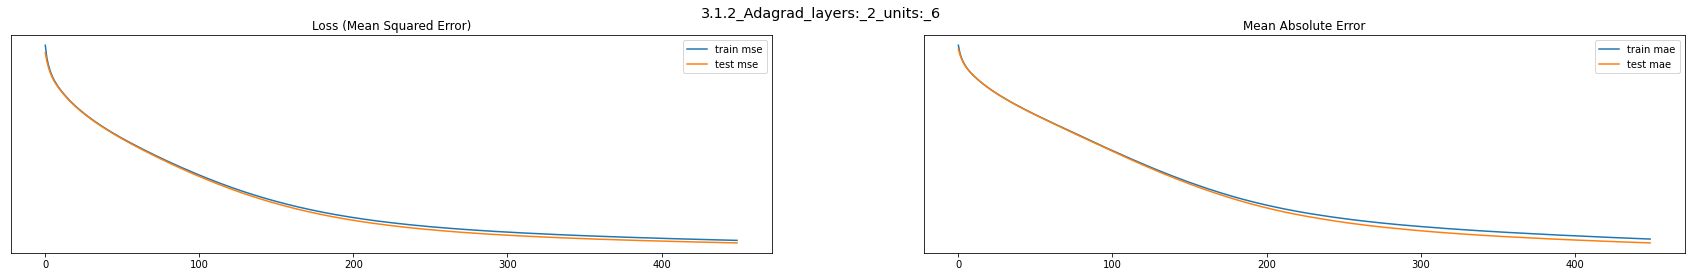

                                      type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_2_units:_6              54.740   
1   test:_3.1.2_Adagrad_layers:_2_units:_6              50.159   
2         3.1.2_Adagrad_layers:_2_units:_6              -4.581   

   mean_absolute_error  r2_score  e_v_score  
0                5.770    81.152     81.153  
1                5.537    82.890     82.893  
2               -0.233    -1.738     -1.740  

Epoch 1: val_loss improved from inf to 0.40460, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_2_units:_8.hdf5

Epoch 2: val_loss improved from 0.40460 to 0.37836, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_2_units:_8.hdf5

Epoch 3: val_loss improved from 0.37836 to 0.35880, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.

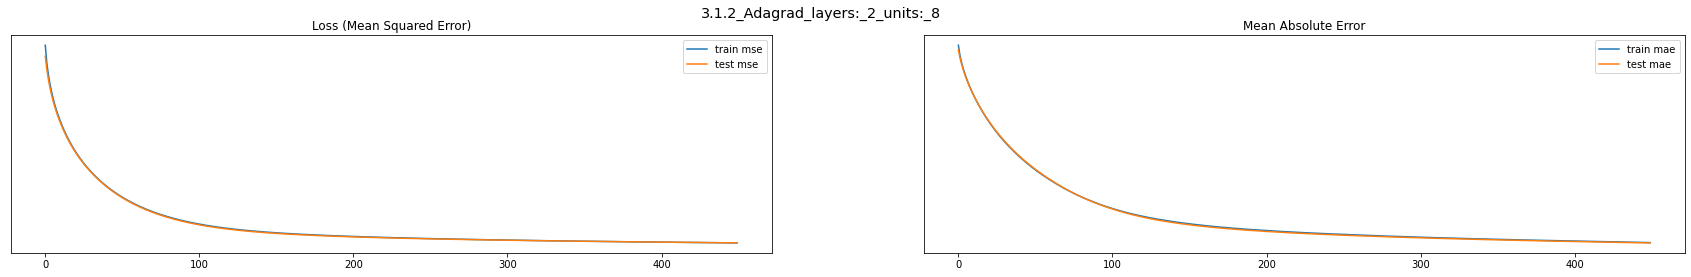

                                      type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_2_units:_8              27.750   
1   test:_3.1.2_Adagrad_layers:_2_units:_8              27.879   
2         3.1.2_Adagrad_layers:_2_units:_8               0.130   

   mean_absolute_error  r2_score  e_v_score  
0                4.152    90.445     90.446  
1                4.134    90.490     90.491  
2               -0.018    -0.045     -0.045  

Epoch 1: val_loss improved from inf to 0.33488, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_2_units:_16.hdf5

Epoch 2: val_loss improved from 0.33488 to 0.31199, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_2_units:_16.hdf5

Epoch 3: val_loss improved from 0.31199 to 0.29487, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_

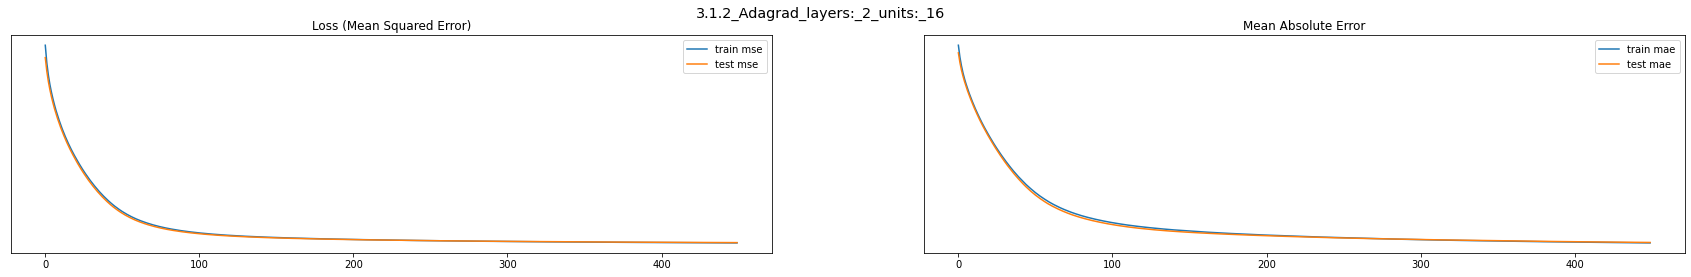

                                       type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_2_units:_16              20.097   
1   test:_3.1.2_Adagrad_layers:_2_units:_16              20.520   
2         3.1.2_Adagrad_layers:_2_units:_16               0.422   

   mean_absolute_error  r2_score  e_v_score  
0                3.519     93.08     93.080  
1                3.545     93.00     93.001  
2                0.026      0.08      0.079  

Epoch 1: val_loss improved from inf to 0.35244, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_2_units:_32.hdf5

Epoch 2: val_loss improved from 0.35244 to 0.31166, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_2_units:_32.hdf5

Epoch 3: val_loss improved from 0.31166 to 0.28018, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weig

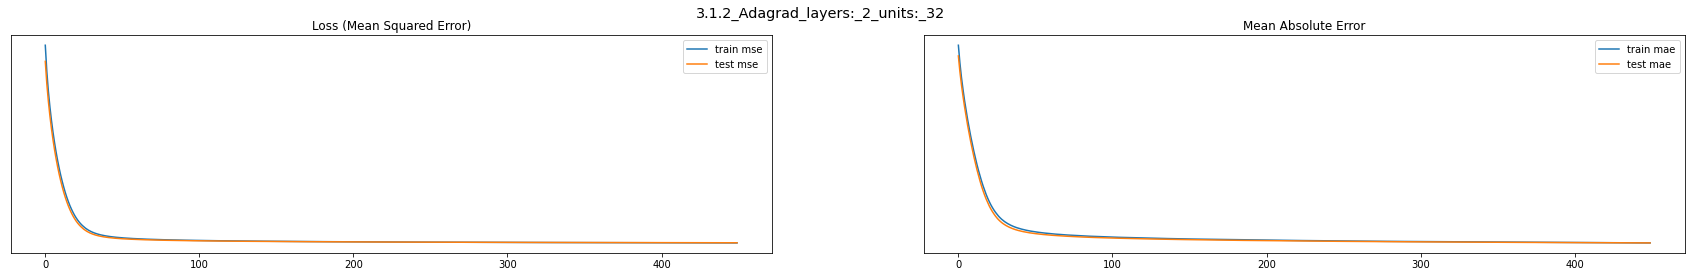

                                       type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_2_units:_32              18.755   
1   test:_3.1.2_Adagrad_layers:_2_units:_32              18.968   
2         3.1.2_Adagrad_layers:_2_units:_32               0.213   

   mean_absolute_error  r2_score  e_v_score  
0                3.378    93.542     93.542  
1                3.380    93.530     93.530  
2                0.001     0.012      0.012  

Epoch 1: val_loss improved from inf to 0.33571, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_2_units:_64.hdf5

Epoch 2: val_loss improved from 0.33571 to 0.30657, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_2_units:_64.hdf5

Epoch 3: val_loss improved from 0.30657 to 0.28166, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weig

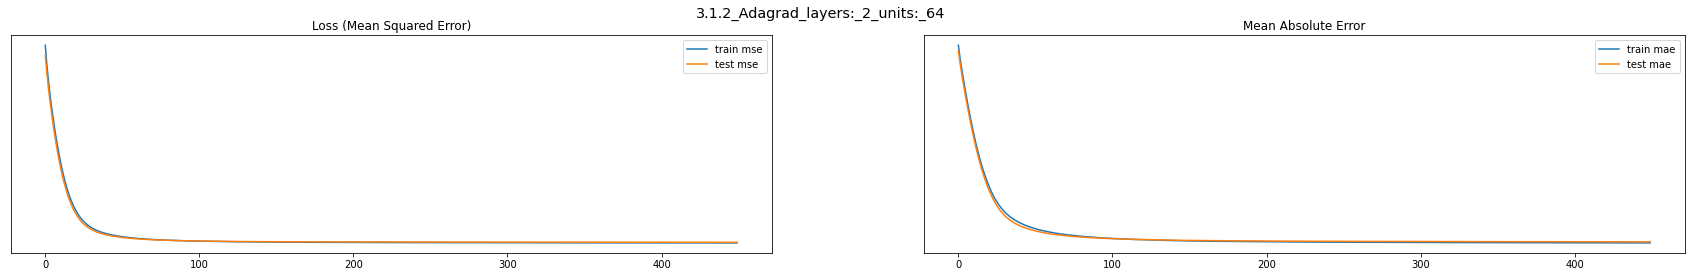

                                       type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_2_units:_64              17.535   
1   test:_3.1.2_Adagrad_layers:_2_units:_64              18.359   
2         3.1.2_Adagrad_layers:_2_units:_64               0.824   

   mean_absolute_error  r2_score  e_v_score  
0                3.250    93.962     93.962  
1                3.311    93.738     93.738  
2                0.060     0.224      0.224  

Epoch 1: val_loss improved from inf to 0.27445, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_2_units:_128.hdf5

Epoch 2: val_loss improved from 0.27445 to 0.23233, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_2_units:_128.hdf5

Epoch 3: val_loss improved from 0.23233 to 0.19916, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-we

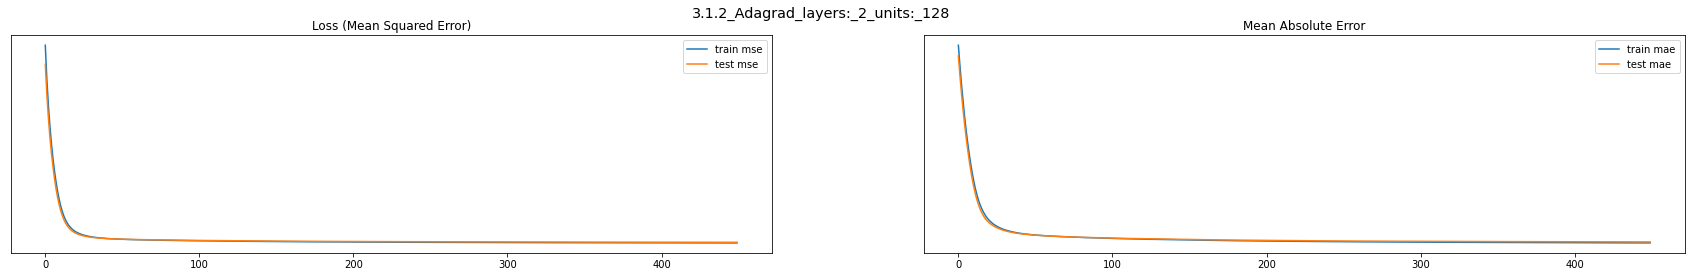

                                        type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_2_units:_128              17.215   
1   test:_3.1.2_Adagrad_layers:_2_units:_128              17.955   
2         3.1.2_Adagrad_layers:_2_units:_128               0.740   

   mean_absolute_error  r2_score  e_v_score  
0                3.208    94.073     94.073  
1                3.260    93.875     93.876  
2                0.051     0.198      0.197  

Epoch 1: val_loss improved from inf to 0.40485, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_4_units:_6.hdf5

Epoch 2: val_loss improved from 0.40485 to 0.39066, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_4_units:_6.hdf5

Epoch 3: val_loss improved from 0.39066 to 0.37967, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-we

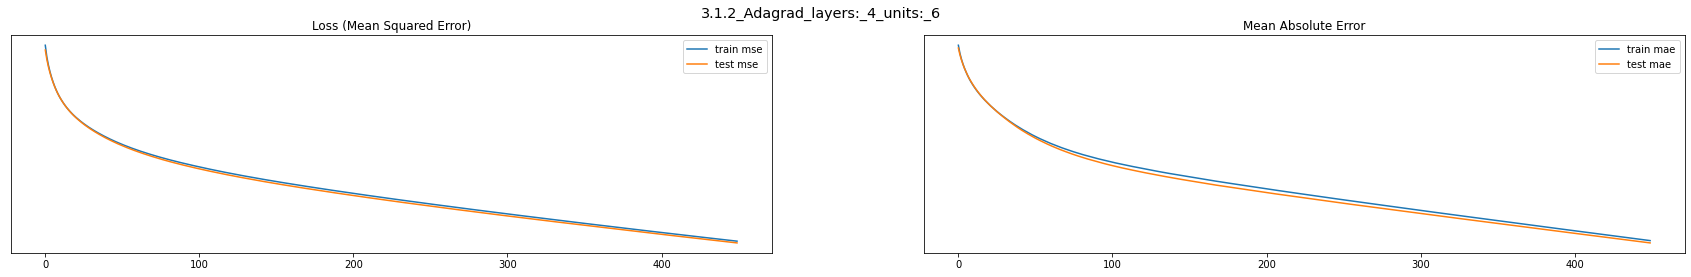

                                      type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_4_units:_6              91.283   
1   test:_3.1.2_Adagrad_layers:_4_units:_6              89.252   
2         3.1.2_Adagrad_layers:_4_units:_6              -2.030   

   mean_absolute_error  r2_score  e_v_score  
0                6.987    68.570     73.019  
1                6.897    69.555     74.159  
2               -0.090    -0.985     -1.140  

Epoch 1: val_loss improved from inf to 0.36366, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_4_units:_8.hdf5

Epoch 2: val_loss improved from 0.36366 to 0.35963, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_4_units:_8.hdf5

Epoch 3: val_loss improved from 0.35963 to 0.35644, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.

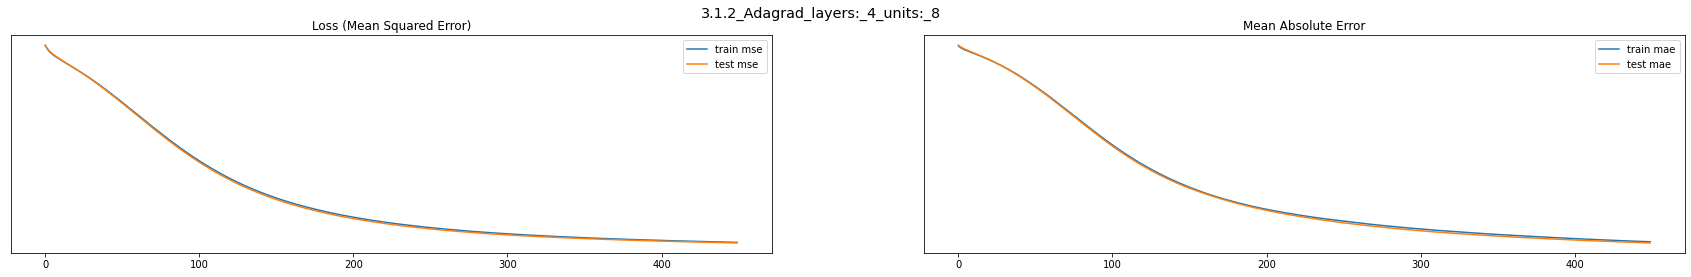

                                      type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_4_units:_8              29.584   
1   test:_3.1.2_Adagrad_layers:_4_units:_8              28.893   
2         3.1.2_Adagrad_layers:_4_units:_8              -0.690   

   mean_absolute_error  r2_score  e_v_score  
0                4.241    89.814     89.826  
1                4.183    90.144     90.169  
2               -0.058    -0.330     -0.343  

Epoch 1: val_loss improved from inf to 0.32343, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_4_units:_16.hdf5

Epoch 2: val_loss improved from 0.32343 to 0.31237, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_4_units:_16.hdf5

Epoch 3: val_loss improved from 0.31237 to 0.30204, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_

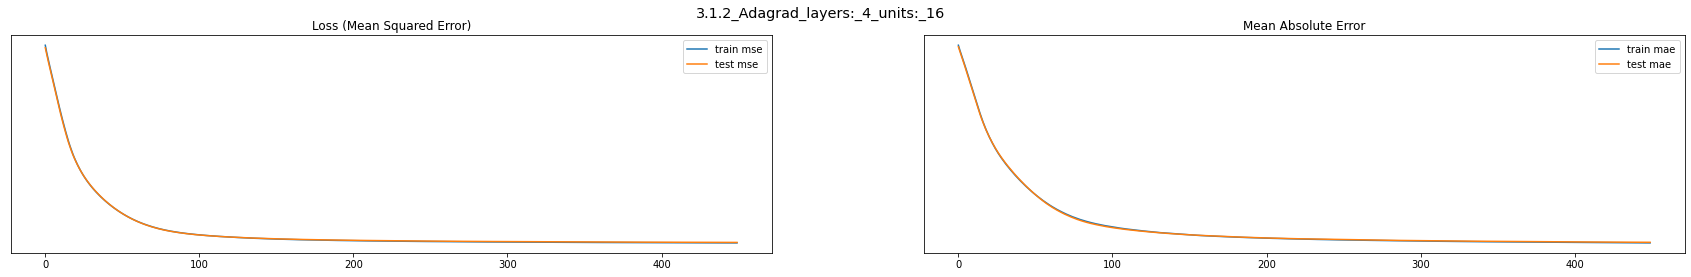

                                       type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_4_units:_16              19.536   
1   test:_3.1.2_Adagrad_layers:_4_units:_16              20.158   
2         3.1.2_Adagrad_layers:_4_units:_16               0.622   

   mean_absolute_error  r2_score  e_v_score  
0                3.445    93.273     93.273  
1                3.479    93.124     93.124  
2                0.034     0.149      0.149  

Epoch 1: val_loss improved from inf to 0.35357, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_4_units:_32.hdf5

Epoch 2: val_loss improved from 0.35357 to 0.33664, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_4_units:_32.hdf5

Epoch 3: val_loss improved from 0.33664 to 0.32114, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weig

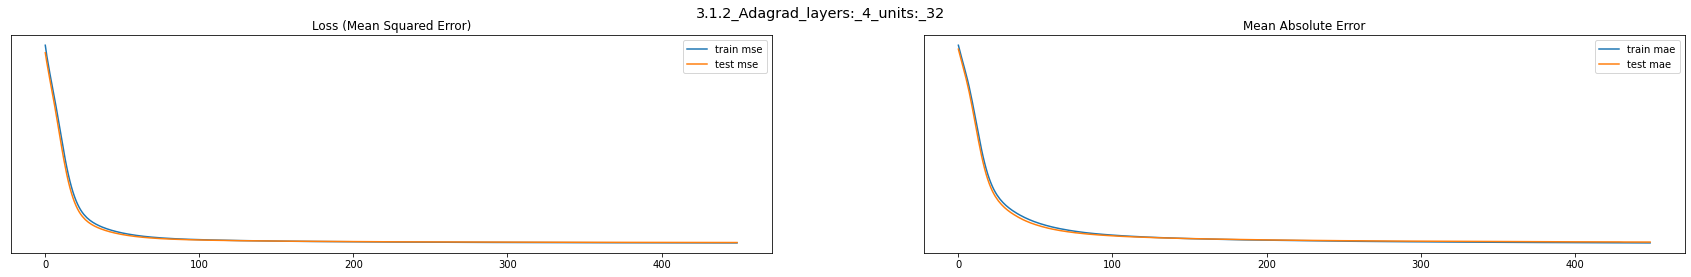

                                       type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_4_units:_32              17.744   
1   test:_3.1.2_Adagrad_layers:_4_units:_32              18.308   
2         3.1.2_Adagrad_layers:_4_units:_32               0.565   

   mean_absolute_error  r2_score  e_v_score  
0                3.283    93.891     93.891  
1                3.332    93.755     93.755  
2                0.049     0.136      0.136  

Epoch 1: val_loss improved from inf to 0.31239, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_4_units:_64.hdf5

Epoch 2: val_loss improved from 0.31239 to 0.28575, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_4_units:_64.hdf5

Epoch 3: val_loss improved from 0.28575 to 0.26179, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weig

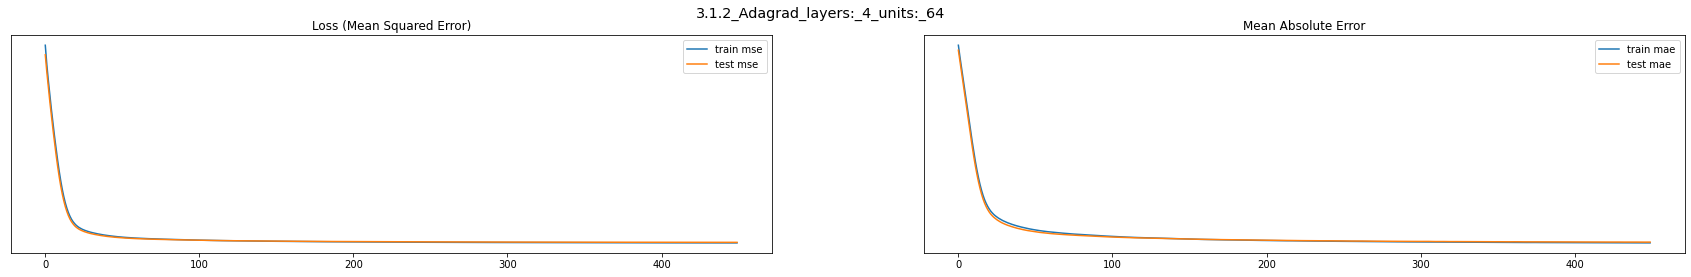

                                       type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_4_units:_64              17.184   
1   test:_3.1.2_Adagrad_layers:_4_units:_64              17.895   
2         3.1.2_Adagrad_layers:_4_units:_64               0.711   

   mean_absolute_error  r2_score  e_v_score  
0                3.211    94.083     94.083  
1                3.253    93.896     93.896  
2                0.042     0.187      0.187  

Epoch 1: val_loss improved from inf to 0.34747, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_4_units:_128.hdf5

Epoch 2: val_loss improved from 0.34747 to 0.31971, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_4_units:_128.hdf5

Epoch 3: val_loss improved from 0.31971 to 0.29423, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-we

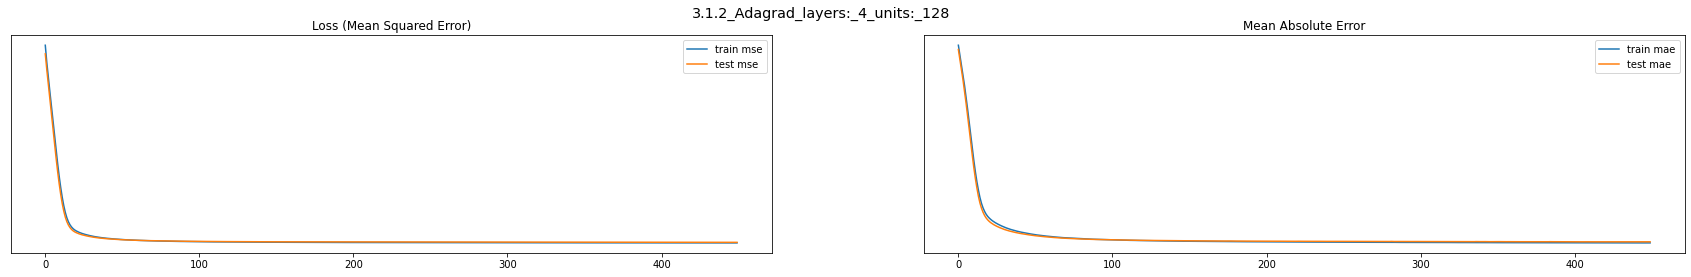

                                        type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_4_units:_128              16.683   
1   test:_3.1.2_Adagrad_layers:_4_units:_128              17.482   
2         3.1.2_Adagrad_layers:_4_units:_128               0.799   

   mean_absolute_error  r2_score  e_v_score  
0                3.158    94.256     94.258  
1                3.220    94.037     94.040  
2                0.062     0.219      0.218  

Epoch 1: val_loss improved from inf to 0.37458, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_6_units:_6.hdf5

Epoch 2: val_loss improved from 0.37458 to 0.37286, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_6_units:_6.hdf5

Epoch 3: val_loss improved from 0.37286 to 0.37187, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-we

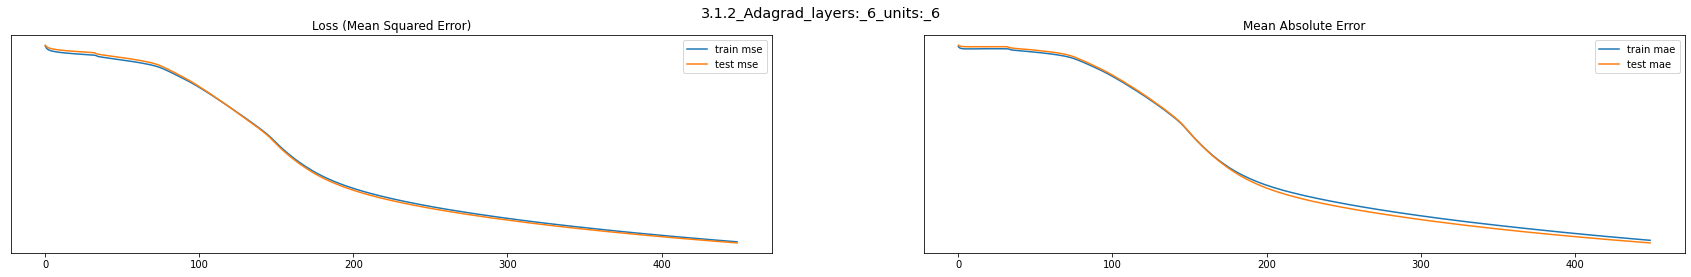

                                      type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_6_units:_6             128.217   
1   test:_3.1.2_Adagrad_layers:_6_units:_6             127.301   
2         3.1.2_Adagrad_layers:_6_units:_6              -0.915   

   mean_absolute_error  r2_score  e_v_score  
0                8.379    55.852     65.739  
1                8.295    56.576     66.874  
2               -0.084    -0.724     -1.135  

Epoch 1: val_loss improved from inf to 0.38789, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_6_units:_8.hdf5

Epoch 2: val_loss improved from 0.38789 to 0.37728, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_6_units:_8.hdf5

Epoch 3: val_loss improved from 0.37728 to 0.37048, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.

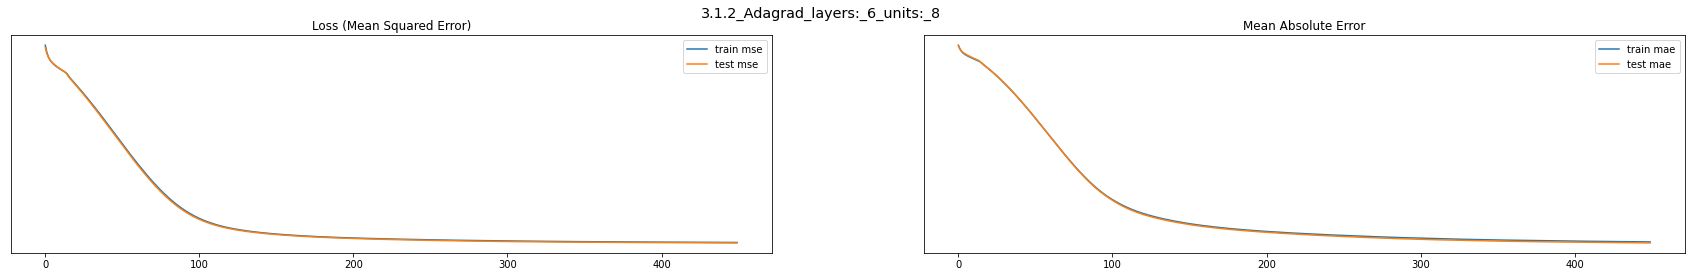

                                      type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_6_units:_8              22.888   
1   test:_3.1.2_Adagrad_layers:_6_units:_8              22.250   
2         3.1.2_Adagrad_layers:_6_units:_8              -0.638   

   mean_absolute_error  r2_score  e_v_score  
0                3.741    92.119     92.119  
1                3.686    92.410     92.411  
2               -0.055    -0.291     -0.292  

Epoch 1: val_loss improved from inf to 0.34548, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_6_units:_16.hdf5

Epoch 2: val_loss improved from 0.34548 to 0.33372, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_6_units:_16.hdf5

Epoch 3: val_loss improved from 0.33372 to 0.32408, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_

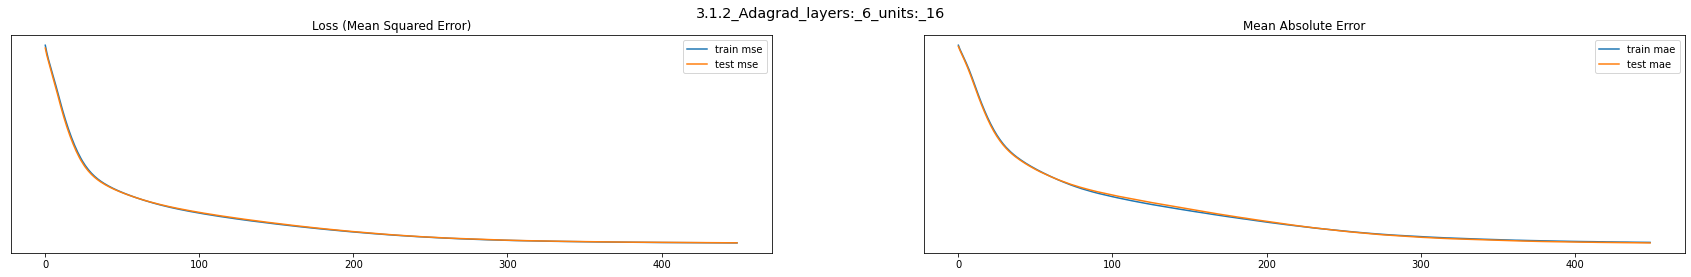

                                       type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_6_units:_16              20.074   
1   test:_3.1.2_Adagrad_layers:_6_units:_16              20.219   
2         3.1.2_Adagrad_layers:_6_units:_16               0.144   

   mean_absolute_error  r2_score  e_v_score  
0                3.486    93.088     93.092  
1                3.460    93.103     93.109  
2               -0.027    -0.015     -0.017  

Epoch 1: val_loss improved from inf to 0.37354, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_6_units:_32.hdf5

Epoch 2: val_loss improved from 0.37354 to 0.36440, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_6_units:_32.hdf5

Epoch 3: val_loss improved from 0.36440 to 0.35623, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weig

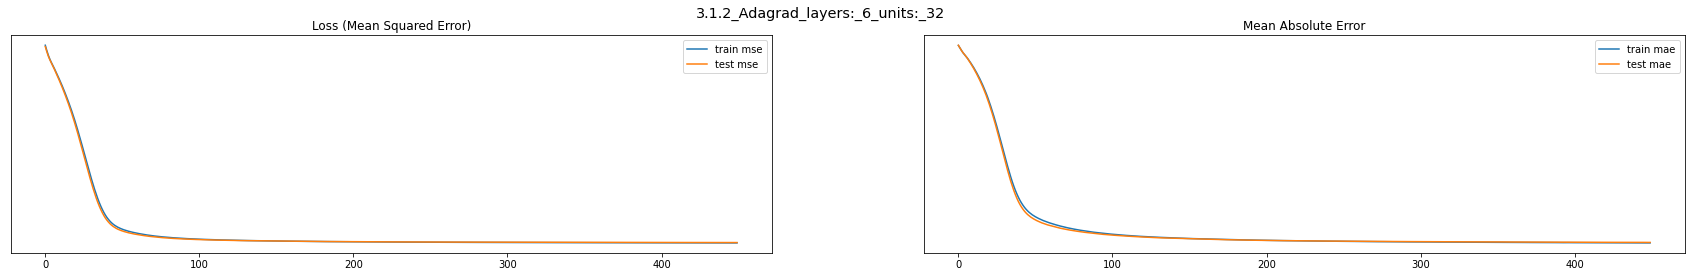

                                       type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_6_units:_32              17.640   
1   test:_3.1.2_Adagrad_layers:_6_units:_32              18.172   
2         3.1.2_Adagrad_layers:_6_units:_32               0.532   

   mean_absolute_error  r2_score  e_v_score  
0                3.249    93.926     93.927  
1                3.278    93.801     93.802  
2                0.030     0.125      0.125  

Epoch 1: val_loss improved from inf to 0.34701, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_6_units:_64.hdf5

Epoch 2: val_loss improved from 0.34701 to 0.33224, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_6_units:_64.hdf5

Epoch 3: val_loss improved from 0.33224 to 0.31819, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weig

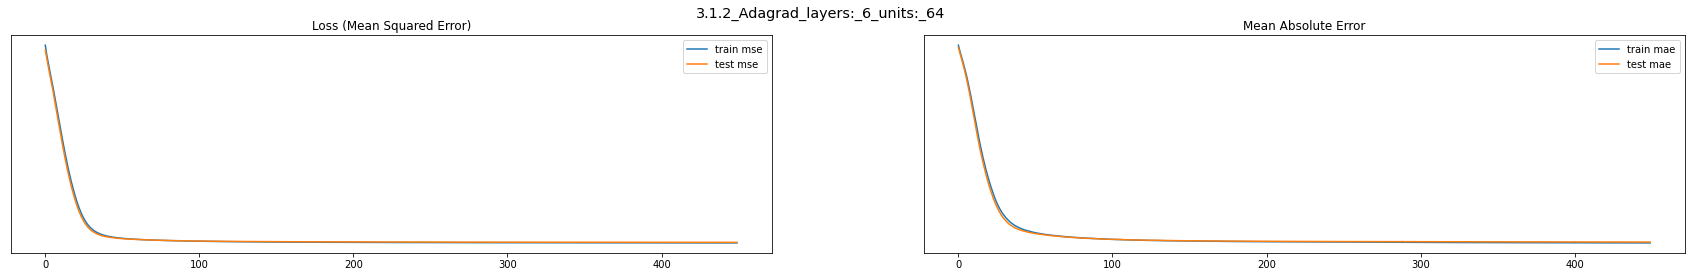

                                       type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_6_units:_64              16.878   
1   test:_3.1.2_Adagrad_layers:_6_units:_64              17.633   
2         3.1.2_Adagrad_layers:_6_units:_64               0.755   

   mean_absolute_error  r2_score  e_v_score  
0                3.167    94.189     94.194  
1                3.215    93.985     93.989  
2                0.048     0.204      0.205  

Epoch 1: val_loss improved from inf to 0.34800, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_6_units:_128.hdf5

Epoch 2: val_loss improved from 0.34800 to 0.33629, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_6_units:_128.hdf5

Epoch 3: val_loss improved from 0.33629 to 0.32467, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-we

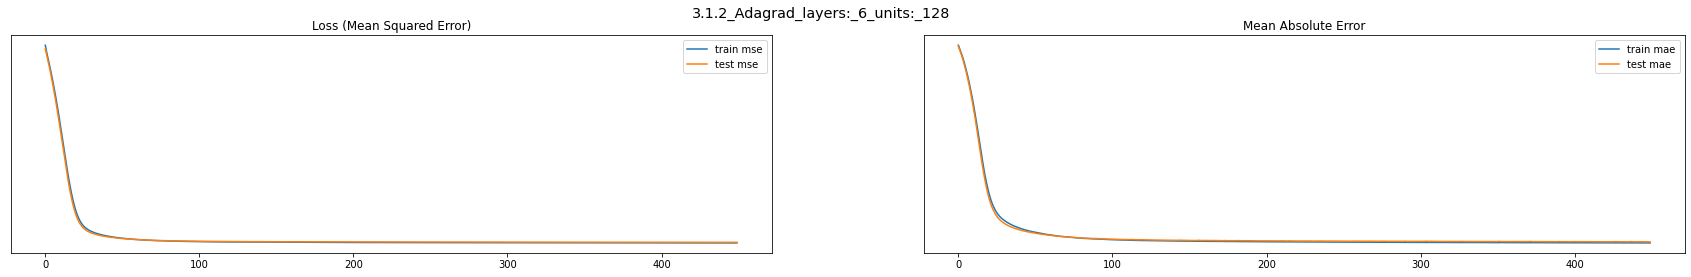

                                        type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_6_units:_128              16.609   
1   test:_3.1.2_Adagrad_layers:_6_units:_128              17.434   
2         3.1.2_Adagrad_layers:_6_units:_128               0.825   

   mean_absolute_error  r2_score  e_v_score  
0                3.137    94.281     94.282  
1                3.198    94.053     94.054  
2                0.061     0.228      0.228  

Epoch 1: val_loss improved from inf to 0.37116, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_8_units:_6.hdf5

Epoch 2: val_loss improved from 0.37116 to 0.36979, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_8_units:_6.hdf5

Epoch 3: val_loss improved from 0.36979 to 0.36868, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-we

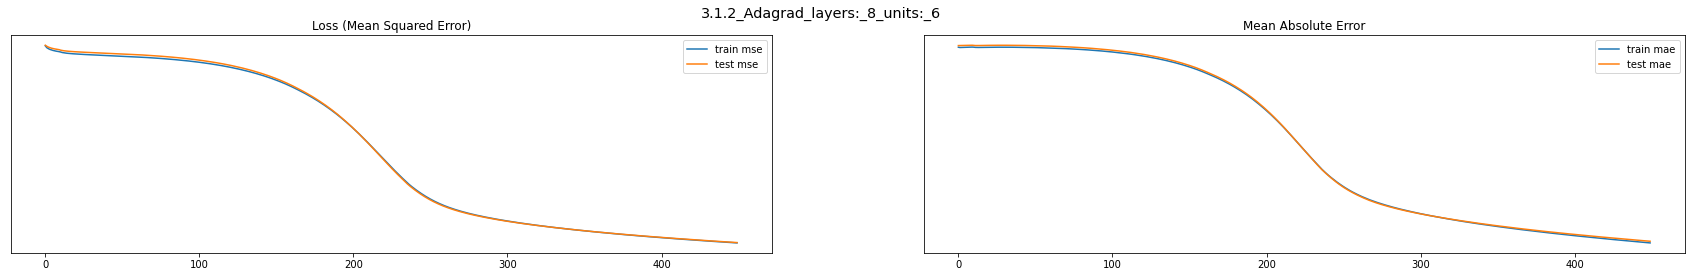

                                      type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_8_units:_6              85.283   
1   test:_3.1.2_Adagrad_layers:_8_units:_6              85.711   
2         3.1.2_Adagrad_layers:_8_units:_6               0.428   

   mean_absolute_error  r2_score  e_v_score  
0                7.395    70.635     76.867  
1                7.459    70.763     77.380  
2                0.065    -0.128     -0.513  

Epoch 1: val_loss improved from inf to 0.35555, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_8_units:_8.hdf5

Epoch 2: val_loss improved from 0.35555 to 0.35035, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_8_units:_8.hdf5

Epoch 3: val_loss improved from 0.35035 to 0.34657, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.

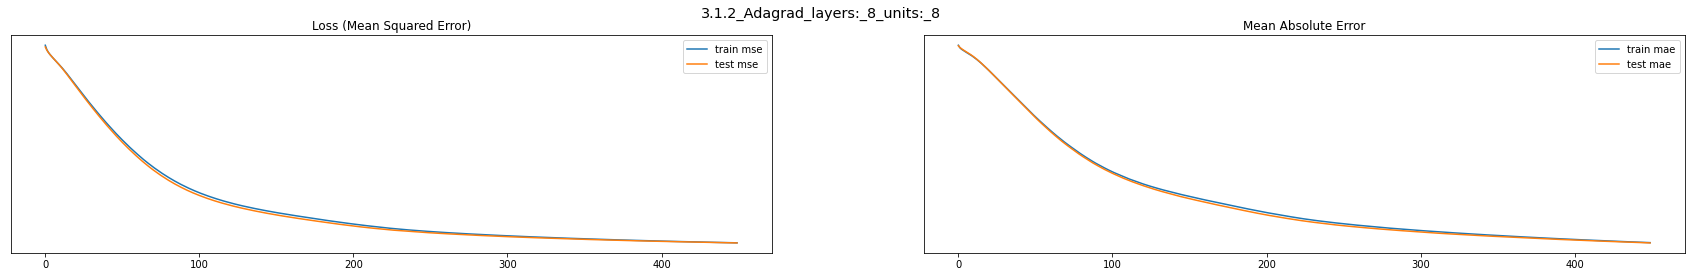

                                      type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_8_units:_8              29.458   
1   test:_3.1.2_Adagrad_layers:_8_units:_8              29.358   
2         3.1.2_Adagrad_layers:_8_units:_8              -0.100   

   mean_absolute_error  r2_score  e_v_score  
0                4.280    89.857     89.857  
1                4.268    89.986     89.992  
2               -0.013    -0.129     -0.135  

Epoch 1: val_loss improved from inf to 0.37039, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_8_units:_16.hdf5

Epoch 2: val_loss improved from 0.37039 to 0.36387, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_8_units:_16.hdf5

Epoch 3: val_loss improved from 0.36387 to 0.35864, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_

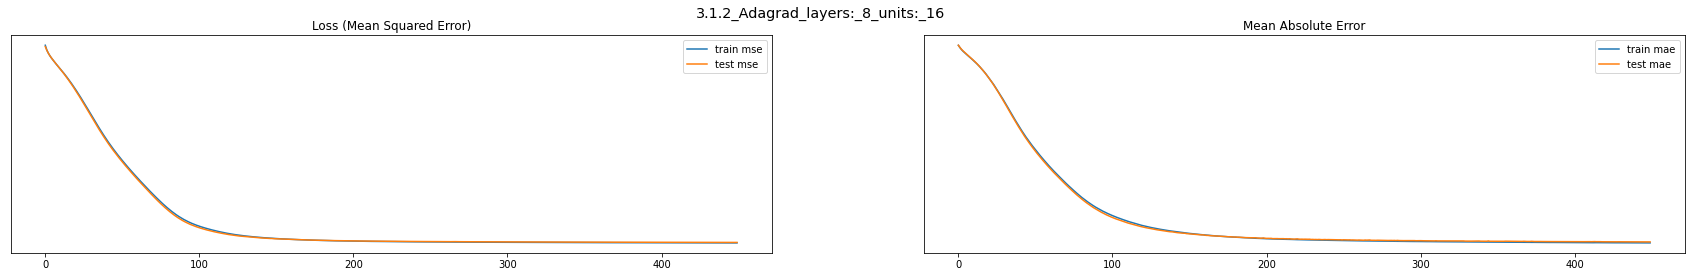

                                       type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_8_units:_16              19.010   
1   test:_3.1.2_Adagrad_layers:_8_units:_16              19.736   
2         3.1.2_Adagrad_layers:_8_units:_16               0.726   

   mean_absolute_error  r2_score  e_v_score  
0                3.379    93.454     93.455  
1                3.436    93.268     93.271  
2                0.057     0.186      0.184  

Epoch 1: val_loss improved from inf to 0.35735, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_8_units:_32.hdf5

Epoch 2: val_loss improved from 0.35735 to 0.35047, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_8_units:_32.hdf5

Epoch 3: val_loss improved from 0.35047 to 0.34547, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weig

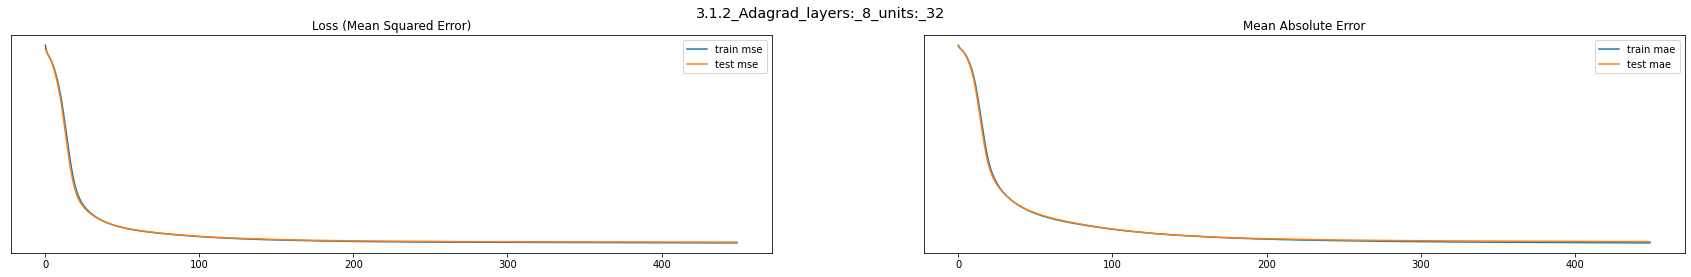

                                       type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_8_units:_32              17.635   
1   test:_3.1.2_Adagrad_layers:_8_units:_32              18.752   
2         3.1.2_Adagrad_layers:_8_units:_32               1.117   

   mean_absolute_error  r2_score  e_v_score  
0                3.262    93.928     93.929  
1                3.337    93.603     93.603  
2                0.075     0.325      0.326  

Epoch 1: val_loss improved from inf to 0.36126, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_8_units:_64.hdf5

Epoch 2: val_loss improved from 0.36126 to 0.35343, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_8_units:_64.hdf5

Epoch 3: val_loss improved from 0.35343 to 0.34647, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weig

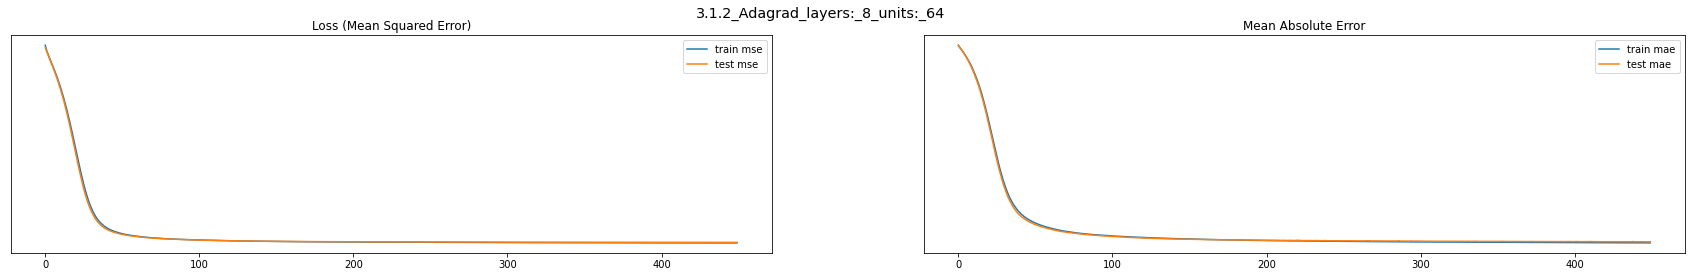

                                       type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_8_units:_64              16.639   
1   test:_3.1.2_Adagrad_layers:_8_units:_64              17.405   
2         3.1.2_Adagrad_layers:_8_units:_64               0.767   

   mean_absolute_error  r2_score  e_v_score  
0                3.150    94.271     94.274  
1                3.215    94.063     94.067  
2                0.065     0.208      0.207  

Epoch 1: val_loss improved from inf to 0.36152, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_8_units:_128.hdf5

Epoch 2: val_loss improved from 0.36152 to 0.35290, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_8_units:_128.hdf5

Epoch 3: val_loss improved from 0.35290 to 0.34402, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-we

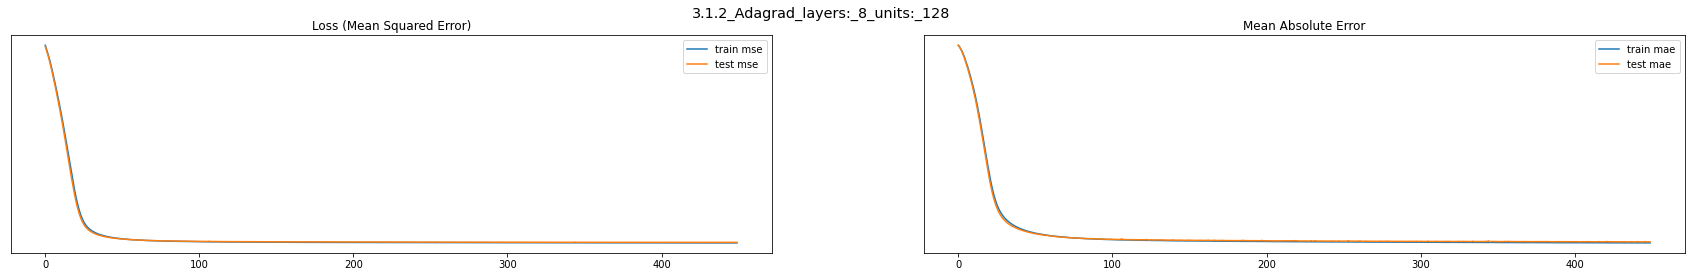

                                        type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_8_units:_128              16.294   
1   test:_3.1.2_Adagrad_layers:_8_units:_128              17.031   
2         3.1.2_Adagrad_layers:_8_units:_128               0.737   

   mean_absolute_error  r2_score  e_v_score  
0                3.104    94.390     94.390  
1                3.164    94.191     94.191  
2                0.061     0.199      0.199  

Epoch 1: val_loss improved from inf to 0.37217, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_10_units:_6.hdf5

Epoch 2: val_loss improved from 0.37217 to 0.36980, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_10_units:_6.hdf5

Epoch 3: val_loss improved from 0.36980 to 0.36868, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-

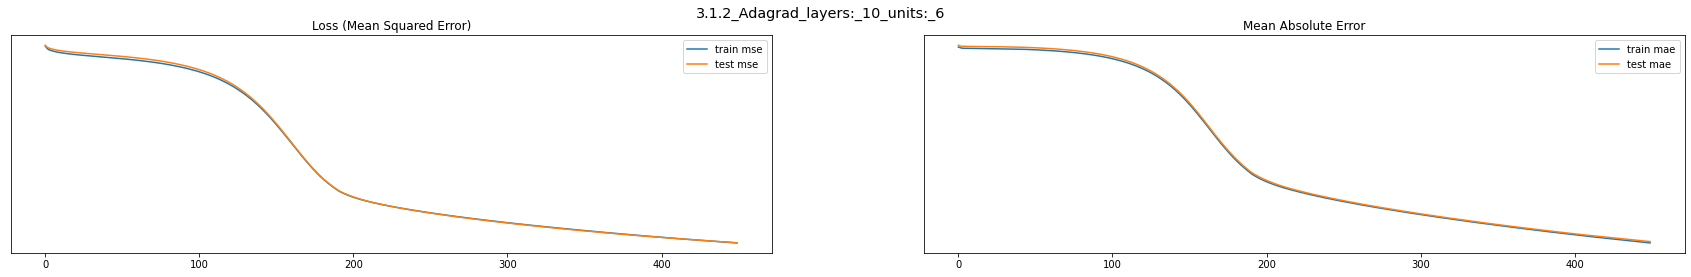

                                       type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_10_units:_6              89.209   
1   test:_3.1.2_Adagrad_layers:_10_units:_6              89.410   
2         3.1.2_Adagrad_layers:_10_units:_6               0.200   

   mean_absolute_error  r2_score  e_v_score  
0                7.631    69.284     75.150  
1                7.682    69.501     75.556  
2                0.051    -0.217     -0.406  

Epoch 1: val_loss improved from inf to 0.36589, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_10_units:_8.hdf5

Epoch 2: val_loss improved from 0.36589 to 0.36476, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_10_units:_8.hdf5

Epoch 3: val_loss improved from 0.36476 to 0.36382, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weig

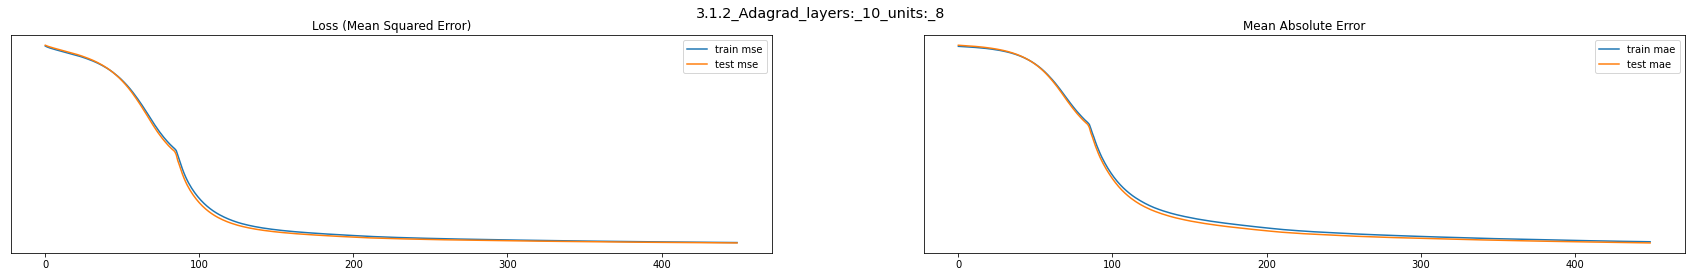

                                       type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_10_units:_8              27.480   
1   test:_3.1.2_Adagrad_layers:_10_units:_8              26.997   
2         3.1.2_Adagrad_layers:_10_units:_8              -0.483   

   mean_absolute_error  r2_score  e_v_score  
0                4.153    90.538     90.538  
1                4.091    90.791     90.792  
2               -0.062    -0.253     -0.254  

Epoch 1: val_loss improved from inf to 0.36511, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_10_units:_16.hdf5

Epoch 2: val_loss improved from 0.36511 to 0.35961, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_10_units:_16.hdf5

Epoch 3: val_loss improved from 0.35961 to 0.35508, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-we

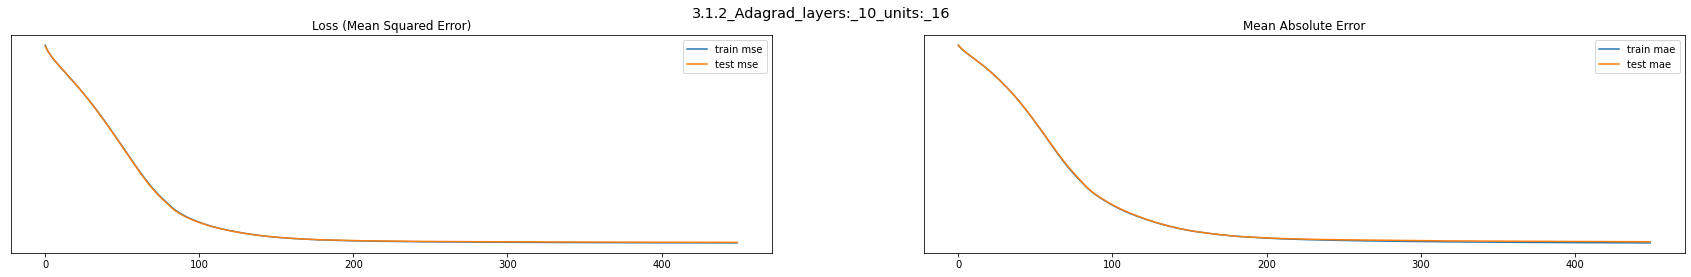

                                        type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_10_units:_16              17.871   
1   test:_3.1.2_Adagrad_layers:_10_units:_16              18.660   
2         3.1.2_Adagrad_layers:_10_units:_16               0.790   

   mean_absolute_error  r2_score  e_v_score  
0                3.267    93.847     93.851  
1                3.337    93.635     93.640  
2                0.070     0.212      0.211  

Epoch 1: val_loss improved from inf to 0.36914, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_10_units:_32.hdf5

Epoch 2: val_loss improved from 0.36914 to 0.36672, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_10_units:_32.hdf5

Epoch 3: val_loss improved from 0.36672 to 0.36483, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resne

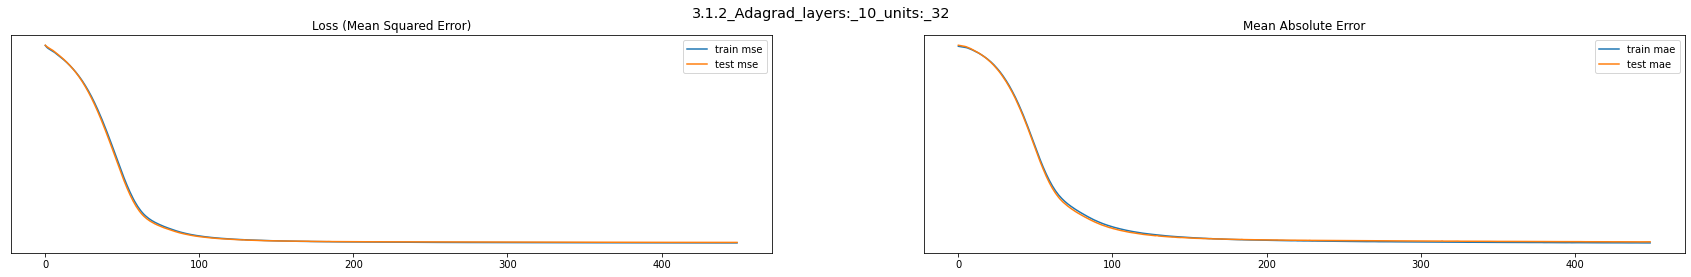

                                        type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_10_units:_32              16.781   
1   test:_3.1.2_Adagrad_layers:_10_units:_32              17.498   
2         3.1.2_Adagrad_layers:_10_units:_32               0.716   

   mean_absolute_error  r2_score  e_v_score  
0                3.164    94.222     94.226  
1                3.224    94.031     94.035  
2                0.060     0.191      0.191  

Epoch 1: val_loss improved from inf to 0.36630, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_10_units:_64.hdf5

Epoch 2: val_loss improved from 0.36630 to 0.36230, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_10_units:_64.hdf5

Epoch 3: val_loss improved from 0.36230 to 0.35914, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resne

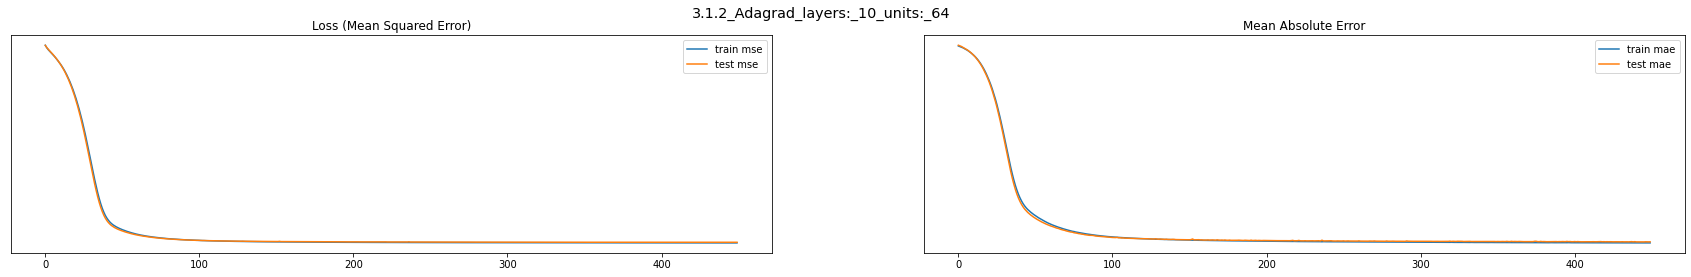

                                        type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_10_units:_64              16.513   
1   test:_3.1.2_Adagrad_layers:_10_units:_64              17.306   
2         3.1.2_Adagrad_layers:_10_units:_64               0.793   

   mean_absolute_error  r2_score  e_v_score  
0                3.123    94.314     94.351  
1                3.183    94.097     94.126  
2                0.060     0.217      0.225  

Epoch 1: val_loss improved from inf to 0.36492, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_10_units:_128.hdf5

Epoch 2: val_loss improved from 0.36492 to 0.35985, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_10_units:_128.hdf5

Epoch 3: val_loss improved from 0.35985 to 0.35504, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/res

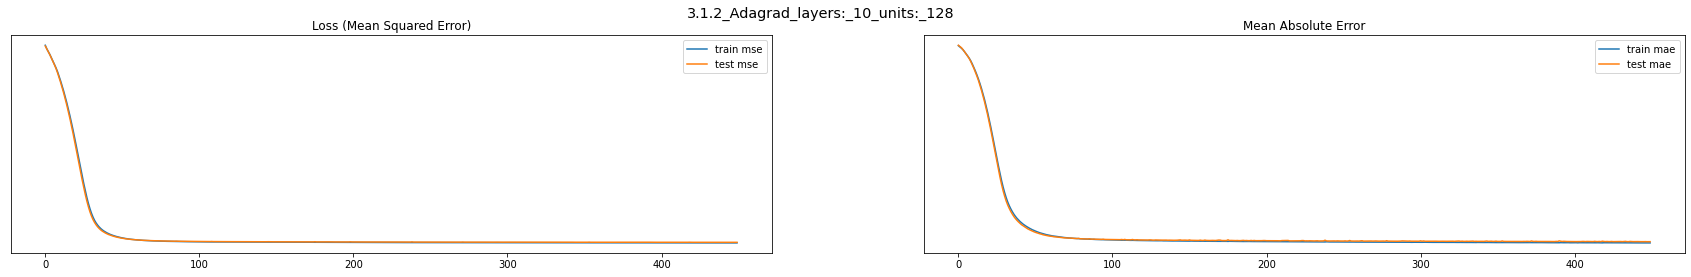

                                         type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_10_units:_128              15.953   
1   test:_3.1.2_Adagrad_layers:_10_units:_128              16.768   
2         3.1.2_Adagrad_layers:_10_units:_128               0.814   

   mean_absolute_error  r2_score  e_v_score  
0                3.055    94.507     94.518  
1                3.128    94.280     94.291  
2                0.073     0.227      0.227  

Epoch 1: val_loss improved from inf to 0.36642, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_15_units:_6.hdf5

Epoch 2: val_loss improved from 0.36642 to 0.36482, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_15_units:_6.hdf5

Epoch 3: val_loss improved from 0.36482 to 0.36371, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/res

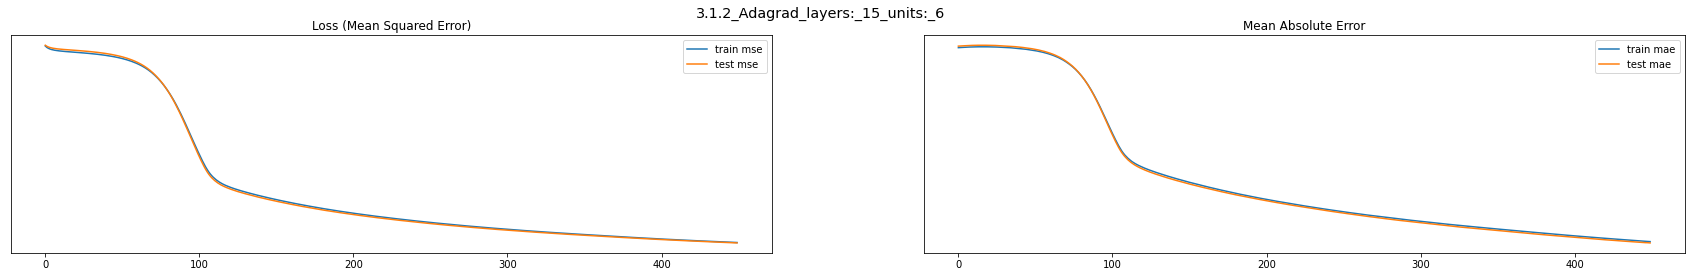

                                       type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_15_units:_6              45.798   
1   test:_3.1.2_Adagrad_layers:_15_units:_6              45.338   
2         3.1.2_Adagrad_layers:_15_units:_6              -0.460   

   mean_absolute_error  r2_score  e_v_score  
0                5.489    84.231     85.223  
1                5.430    84.535     85.574  
2               -0.059    -0.304     -0.351  

Epoch 1: val_loss improved from inf to 0.36926, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_15_units:_8.hdf5

Epoch 2: val_loss improved from 0.36926 to 0.36628, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_15_units:_8.hdf5

Epoch 3: val_loss improved from 0.36628 to 0.36233, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weig

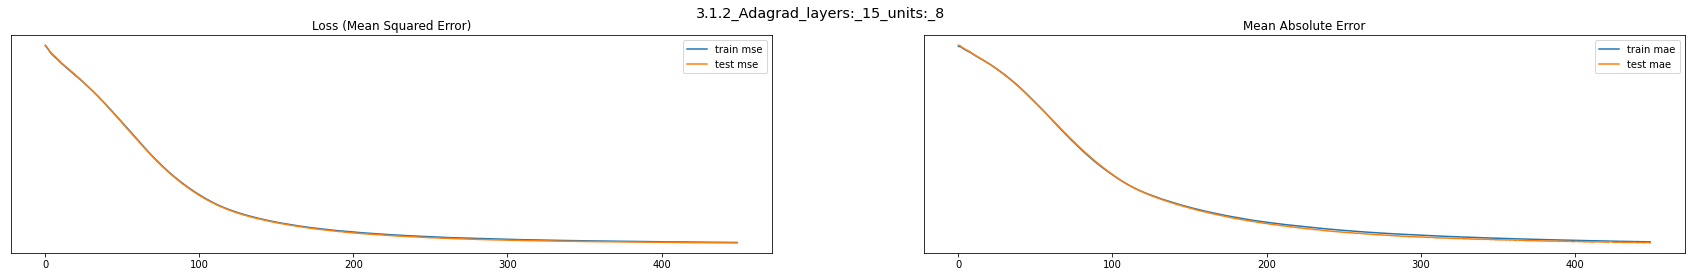

                                       type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_15_units:_8              25.057   
1   test:_3.1.2_Adagrad_layers:_15_units:_8              24.386   
2         3.1.2_Adagrad_layers:_15_units:_8              -0.670   

   mean_absolute_error  r2_score  e_v_score  
0                3.880    91.373     91.380  
1                3.824    91.682     91.684  
2               -0.055    -0.309     -0.304  

Epoch 1: val_loss improved from inf to 0.36918, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_15_units:_16.hdf5

Epoch 2: val_loss improved from 0.36918 to 0.36733, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_15_units:_16.hdf5

Epoch 3: val_loss improved from 0.36733 to 0.36610, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-we

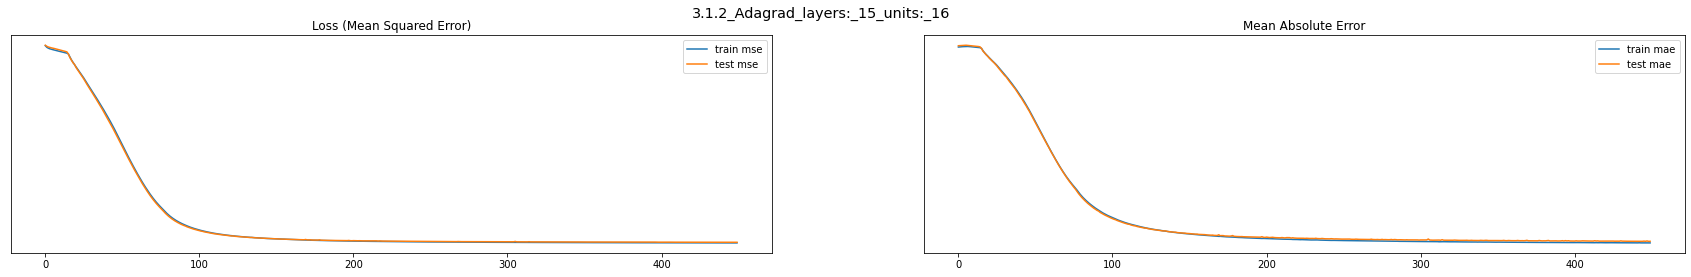

                                        type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_15_units:_16              17.493   
1   test:_3.1.2_Adagrad_layers:_15_units:_16              18.405   
2         3.1.2_Adagrad_layers:_15_units:_16               0.912   

   mean_absolute_error  r2_score  e_v_score  
0                3.219    93.977     93.977  
1                3.315    93.722     93.724  
2                0.096     0.255      0.253  

Epoch 1: val_loss improved from inf to 0.36911, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_15_units:_32.hdf5

Epoch 2: val_loss improved from 0.36911 to 0.36640, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_15_units:_32.hdf5

Epoch 3: val_loss improved from 0.36640 to 0.36426, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resne

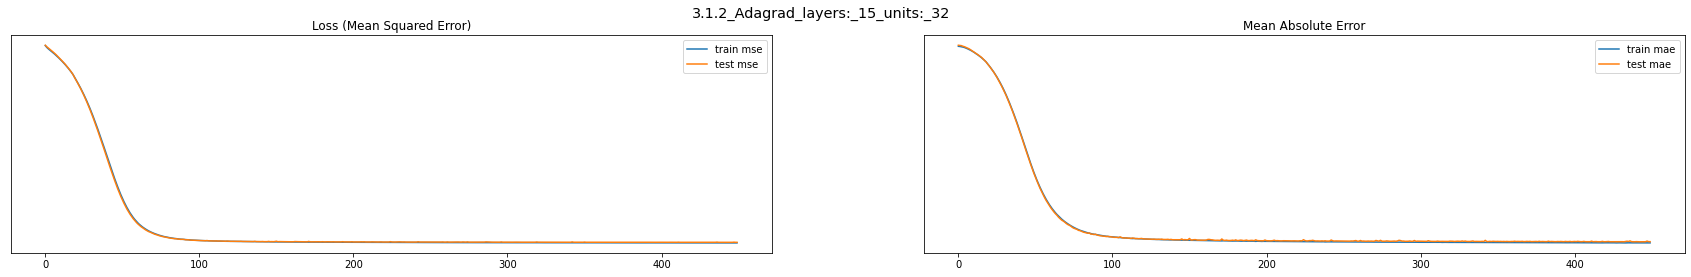

                                        type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_15_units:_32              16.559   
1   test:_3.1.2_Adagrad_layers:_15_units:_32              17.421   
2         3.1.2_Adagrad_layers:_15_units:_32               0.862   

   mean_absolute_error  r2_score  e_v_score  
0                3.124    94.298     94.299  
1                3.197    94.058     94.061  
2                0.073     0.240      0.238  

Epoch 1: val_loss improved from inf to 0.36919, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_15_units:_64.hdf5

Epoch 2: val_loss improved from 0.36919 to 0.36621, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_15_units:_64.hdf5

Epoch 3: val_loss improved from 0.36621 to 0.36406, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resne

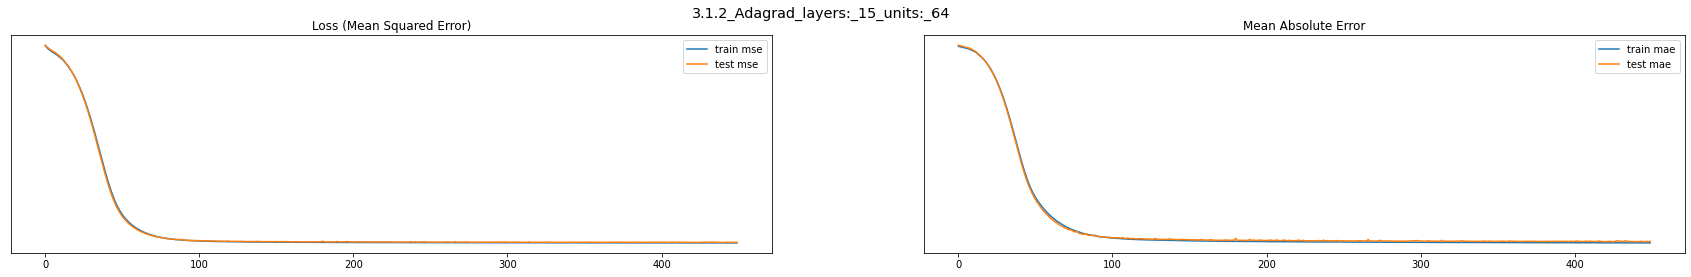

                                        type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_15_units:_64              16.152   
1   test:_3.1.2_Adagrad_layers:_15_units:_64              16.903   
2         3.1.2_Adagrad_layers:_15_units:_64               0.752   

   mean_absolute_error  r2_score  e_v_score  
0                3.082    94.439     94.471  
1                3.156    94.234     94.265  
2                0.074     0.205      0.206  

Epoch 1: val_loss improved from inf to 0.36812, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_15_units:_128.hdf5

Epoch 2: val_loss improved from 0.36812 to 0.36522, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_15_units:_128.hdf5

Epoch 3: val_loss improved from 0.36522 to 0.36267, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/res

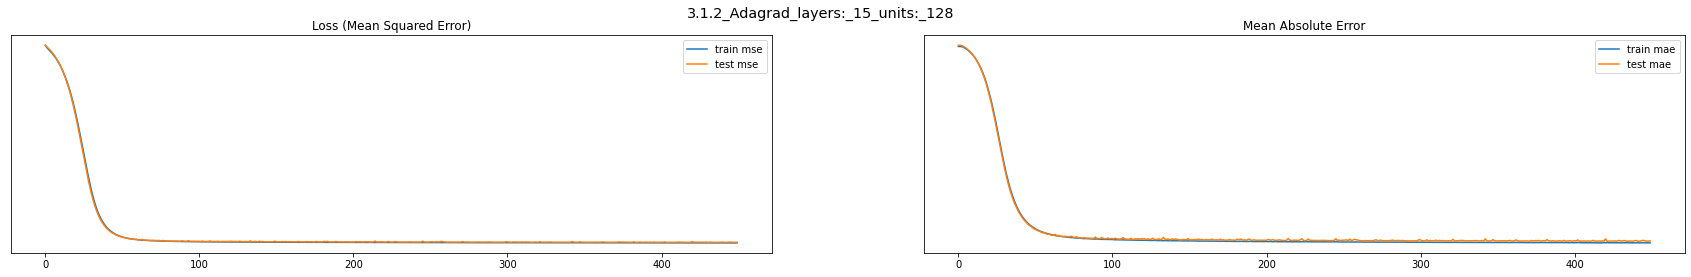

                                         type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_15_units:_128              15.314   
1   test:_3.1.2_Adagrad_layers:_15_units:_128              16.187   
2         3.1.2_Adagrad_layers:_15_units:_128               0.873   

   mean_absolute_error  r2_score  e_v_score  
0                2.986    94.727     94.775  
1                3.088    94.478     94.530  
2                0.102     0.249      0.245  

Epoch 1: val_loss improved from inf to 0.37223, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_20_units:_6.hdf5

Epoch 2: val_loss improved from 0.37223 to 0.37160, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_20_units:_6.hdf5

Epoch 3: val_loss improved from 0.37160 to 0.37113, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/res

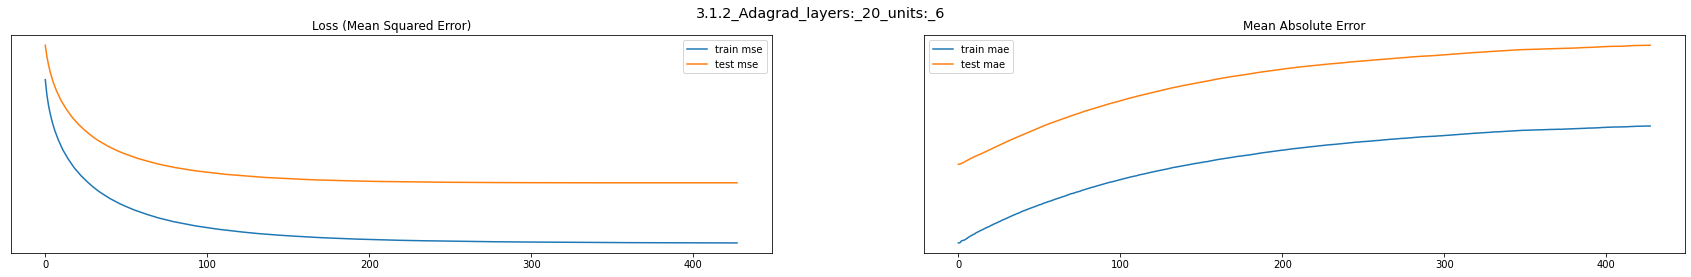

                                       type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_20_units:_6             290.441   
1   test:_3.1.2_Adagrad_layers:_20_units:_6             293.161   
2         3.1.2_Adagrad_layers:_20_units:_6               2.720   

   mean_absolute_error  r2_score  e_v_score  
0               14.808    -0.005        0.0  
1               14.883    -0.000        0.0  
2                0.075    -0.005        0.0  

Epoch 1: val_loss improved from inf to 0.37151, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_20_units:_8.hdf5

Epoch 2: val_loss improved from 0.37151 to 0.37064, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_20_units:_8.hdf5

Epoch 3: val_loss improved from 0.37064 to 0.36995, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weig

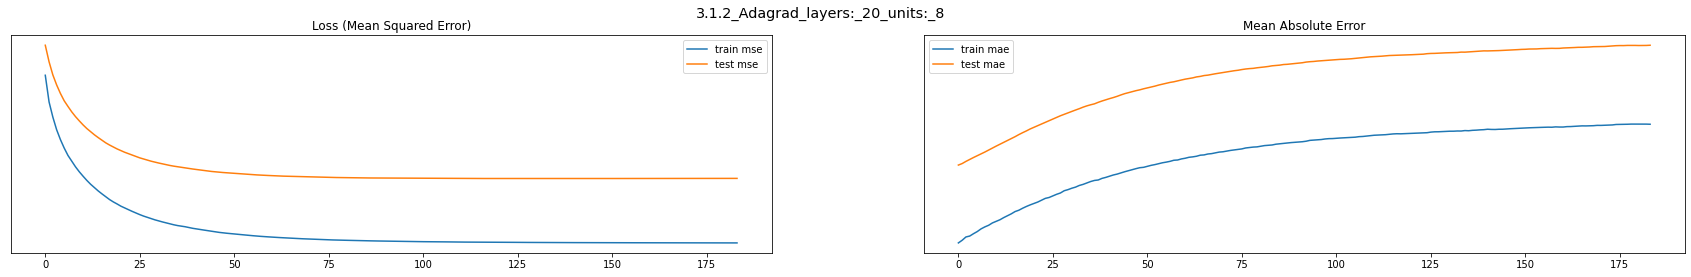

                                       type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_20_units:_8             290.432   
1   test:_3.1.2_Adagrad_layers:_20_units:_8             293.166   
2         3.1.2_Adagrad_layers:_20_units:_8               2.734   

   mean_absolute_error  r2_score  e_v_score  
0               14.812    -0.002        0.0  
1               14.887    -0.002        0.0  
2                0.075     0.000        0.0  

Epoch 1: val_loss improved from inf to 0.36832, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_20_units:_16.hdf5

Epoch 2: val_loss improved from 0.36832 to 0.36629, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_20_units:_16.hdf5

Epoch 3: val_loss improved from 0.36629 to 0.36545, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-we

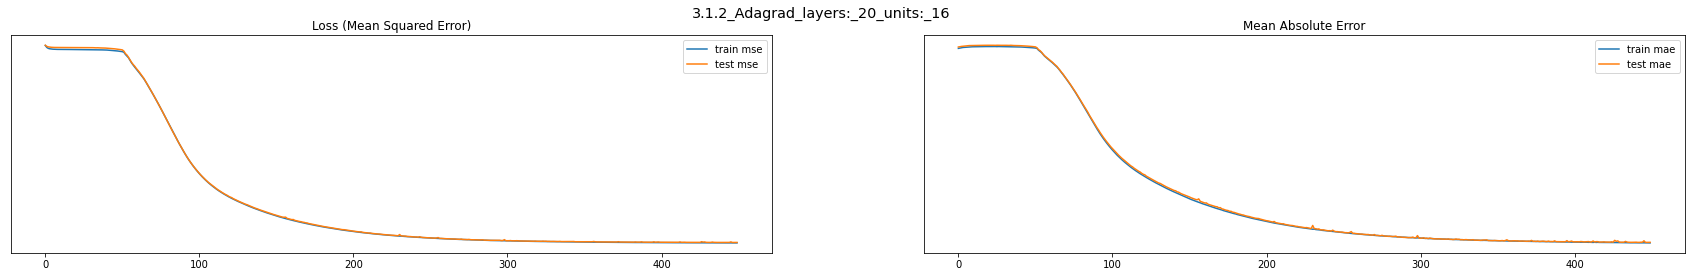

                                        type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_20_units:_16              18.519   
1   test:_3.1.2_Adagrad_layers:_20_units:_16              19.157   
2         3.1.2_Adagrad_layers:_20_units:_16               0.638   

   mean_absolute_error  r2_score  e_v_score  
0                3.298    93.624     93.665  
1                3.333    93.465     93.505  
2                0.035     0.159      0.160  

Epoch 1: val_loss improved from inf to 0.36953, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_20_units:_32.hdf5

Epoch 2: val_loss improved from 0.36953 to 0.36616, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_20_units:_32.hdf5

Epoch 3: val_loss improved from 0.36616 to 0.36388, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resne

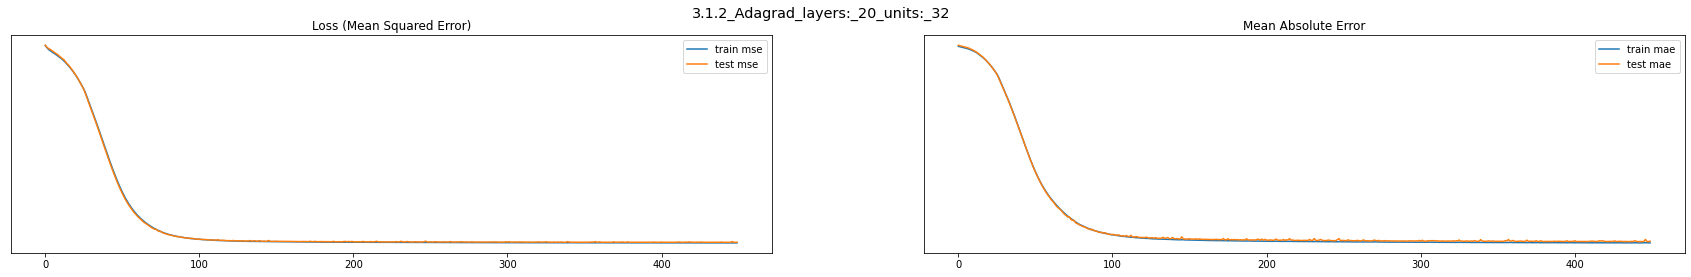

                                        type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_20_units:_32               16.39   
1   test:_3.1.2_Adagrad_layers:_20_units:_32               17.26   
2         3.1.2_Adagrad_layers:_20_units:_32                0.87   

   mean_absolute_error  r2_score  e_v_score  
0                3.117    94.357     94.403  
1                3.194    94.112     94.167  
2                0.077     0.245      0.236  

Epoch 1: val_loss improved from inf to 0.37033, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_20_units:_64.hdf5

Epoch 2: val_loss improved from 0.37033 to 0.36867, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_20_units:_64.hdf5

Epoch 3: val_loss improved from 0.36867 to 0.36731, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resne

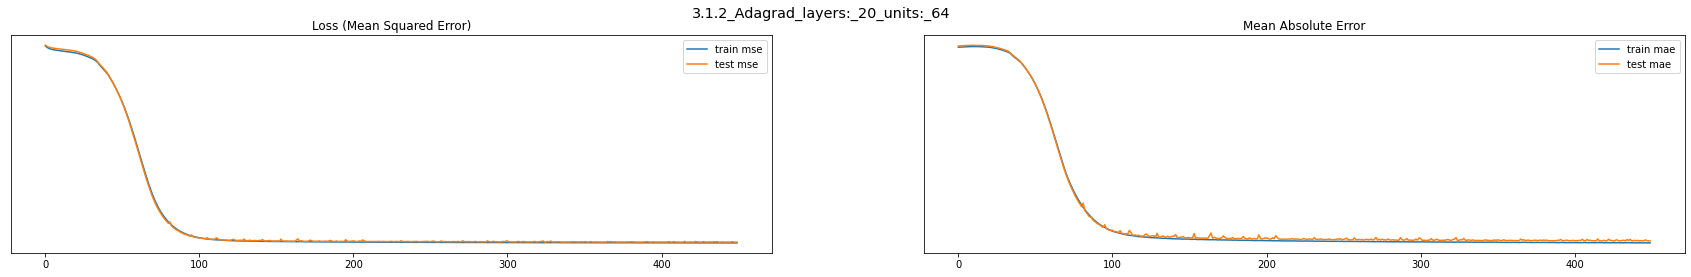

                                        type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_20_units:_64              15.491   
1   test:_3.1.2_Adagrad_layers:_20_units:_64              16.628   
2         3.1.2_Adagrad_layers:_20_units:_64               1.137   

   mean_absolute_error  r2_score  e_v_score  
0                2.994    94.666     94.690  
1                3.111    94.328     94.354  
2                0.117     0.338      0.336  

Epoch 1: val_loss improved from inf to 0.36847, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_20_units:_128.hdf5

Epoch 2: val_loss improved from 0.36847 to 0.36549, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.2_Adagrad_layers:_20_units:_128.hdf5

Epoch 3: val_loss improved from 0.36549 to 0.36198, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/res

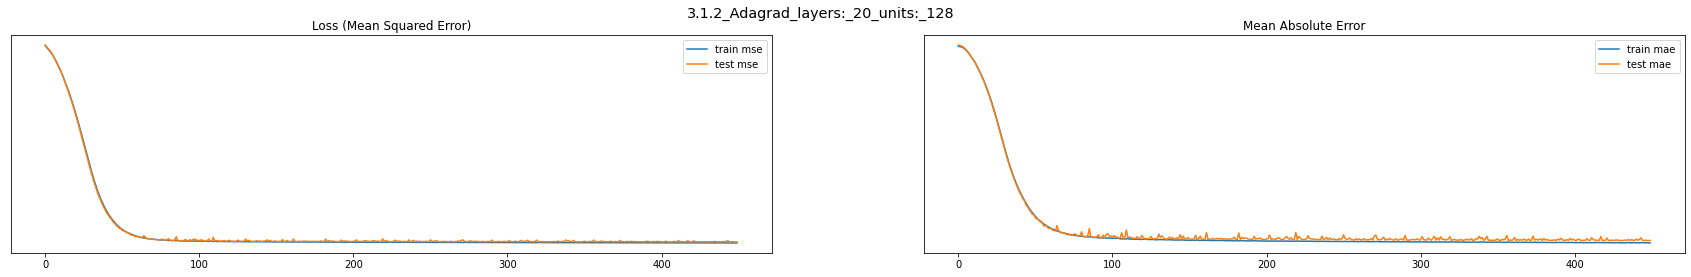

                                         type  mean_squared_error  \
0  train:_3.1.2_Adagrad_layers:_20_units:_128              14.601   
1   test:_3.1.2_Adagrad_layers:_20_units:_128              16.052   
2         3.1.2_Adagrad_layers:_20_units:_128               1.450   

   mean_absolute_error  r2_score  e_v_score  
0                2.903    94.972      95.00  
1                3.042    94.525      94.55  
2                0.140     0.447       0.45  


In [ ]:
rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
yj_transformer = PowerTransformer(method = 'yeo-johnson', standardize = False)

pipe_complex = define_pipeline_complex(RobustScaler(),yj_transformer, rcpr_transformer, False, True)
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_complex, KNNImputer(n_neighbors=2), True, True)
nlayers = [2,4,6,8,10,15,20]
units = [6,8,16,32,64,128]
for nl in nlayers:
  for u in units:
    complete_run (f"3.1.2_Adagrad_layers:_{nl}_units:_{u}",  pipe, opt = 'adagrad', n_layers = nl, unt = u)

In [ ]:
show_results(False)

MSE 
 
 
   
 modelName 
 train_mse 
 test_mse 
 difference 
 
 
 
 
 4 
 No3.1.1_Adam_layers:_2_units:_32 
 12.987 
 15.232 
 2.245 
 
 
 5 
 No3.1.1_Adam_layers:_6_units:_32 
 12.322 
 15.302 
 2.980 
 
 
 3 
 No3.1.1_Adam_layers:_6_units:_16 
 13.874 
 15.533 
 1.658 
 
 
 47 
 3.1.2_Adagrad_layers:_20_units:_128 
 14.601 
 16.052 
 1.450 
 
 
 41 
 3.1.2_Adagrad_layers:_15_units:_128 
 15.314 
 16.187 
 0.873 
 
 
 46 
 3.1.2_Adagrad_layers:_20_units:_64 
 15.491 
 16.628 
 1.137 
 
 
 35 
 3.1.2_Adagrad_layers:_10_units:_128 
 15.953 
 16.768 
 0.814 
 
 
 40 
 3.1.2_Adagrad_layers:_15_units:_64 
 16.152 
 16.903 
 0.752 
 
 
 29 
 3.1.2_Adagrad_layers:_8_units:_128 
 16.294 
 17.031 
 0.737 
 
 
 45 
 3.1.2_Adagrad_layers:_20_units:_32 
 16.390 
 17.260 
 0.870 
 
 
 34 
 3.1.2_Adagrad_layers:_10_units:_64 
 16.513 
 17.306 
 0.793 
 
 
 28 
 3.1.2_Adagrad_layers:_8_units:_64 
 16.639 
 17.405 
 0.767 
 
 
 39 
 3.1.2_Adagrad_layers:_15_units:_32 
 16.559 
 17.421 
 0.862 
 
 
 23 
 3.1.2_Adagrad_layers:_6_units:_128 
 16.609 
 17.434 
 0.825 
 
 
 2 
 RS_RH_AP_winsorize_RCPR_na_ann_knn 
 16.928 
 17.442 
 0.514 
 
 
 17 
 3.1.2_Adagrad_layers:_4_units:_128 
 16.683 
 17.482 
 0.799 
 
 
 33 
 3.1.2_Adagrad_layers:_10_units:_32 
 16.781 
 17.498 
 0.716 
 
 
 22 
 3.1.2_Adagrad_layers:_6_units:_64 
 16.878 
 17.633 
 0.755 
 
 
 1 
 base_ann 
 16.975 
 17.756 
 0.781 
 
 
 16 
 3.1.2_Adagrad_layers:_4_units:_64 
 17.184 
 17.895 
 0.711 
 
 
 11 
 3.1.2_Adagrad_layers:_2_units:_128 
 17.215 
 17.955 
 0.740 
 
 
 21 
 3.1.2_Adagrad_layers:_6_units:_32 
 17.640 
 18.172 
 0.532 
 
 
 15 
 3.1.2_Adagrad_layers:_4_units:_32 
 17.744 
 18.308 
 0.565 
 
 
 10 
 3.1.2_Adagrad_layers:_2_units:_64 
 17.535 
 18.359 
 0.824 
 
 
 38 
 3.1.2_Adagrad_layers:_15_units:_16 
 17.493 
 18.405 
 0.912 
 
 
 32 
 3.1.2_Adagrad_layers:_10_units:_16 
 17.871 
 18.660 
 0.790 
 
 
 27 
 3.1.2_Adagrad_layers:_8_units:_32 
 17.635 
 18.752 
 1.117 
 
 
 9 
 3.1.2_Adagrad_layers:_2_units:_32 
 18.755 
 18.968 
 0.213 
 
 
 44 
 3.1.2_Adagrad_layers:_20_units:_16 
 18.519 
 19.157 
 0.638 
 
 
 26 
 3.1.2_Adagrad_layers:_8_units:_16 
 19.010 
 19.736 
 0.726 
 
 
 14 
 3.1.2_Adagrad_layers:_4_units:_16 
 19.536 
 20.158 
 0.622 
 
 
 20 
 3.1.2_Adagrad_layers:_6_units:_16 
 20.074 
 20.219 
 0.144 
 
 
 8 
 3.1.2_Adagrad_layers:_2_units:_16 
 20.097 
 20.520 
 0.422 
 
 
 0 
 basemodel 
 21.448 
 22.164 
 0.716 
 
 
 19 
 3.1.2_Adagrad_layers:_6_units:_8 
 22.888 
 22.250 
 -0.638 
 
 
 37 
 3.1.2_Adagrad_layers:_15_units:_8 
 25.057 
 24.386 
 -0.670 
 
 
 31 
 3.1.2_Adagrad_layers:_10_units:_8 
 27.480 
 26.997 
 -0.483 
 
 
 7 
 3.1.2_Adagrad_layers:_2_units:_8 
 27.750 
 27.879 
 0.130 
 
 
 13 
 3.1.2_Adagrad_layers:_4_units:_8 
 29.584 
 28.893 
 -0.690 
 
 
 25 
 3.1.2_Adagrad_layers:_8_units:_8 
 29.458 
 29.358 
 -0.100 
 
 
 36 
 3.1.2_Adagrad_layers:_15_units:_6 
 45.798 
 45.338 
 -0.460 
 
 
 6 
 3.1.2_Adagrad_layers:_2_units:_6 
 54.740 
 50.159 
 -4.581 
 
 
 24 
 3.1.2_Adagrad_layers:_8_units:_6 
 85.283 
 85.711 
 0.428 
 
 
 12 
 3.1.2_Adagrad_layers:_4_units:_6 
 91.283 
 89.252 
 -2.030 
 
 
 30 
 3.1.2_Adagrad_layers:_10_units:_6 
 89.209 
 89.410 
 0.200 
 
 
 18 
 3.1.2_Adagrad_layers:_6_units:_6 
 128.217 
 127.301 
 -0.915 
 
 
 42 
 3.1.2_Adagrad_layers:_20_units:_6 
 290.441 
 293.161 
 2.720 
 
 
 43 
 3.1.2_Adagrad_layers:_20_units:_8 
 290.432 
 293.166 
 2.734 
 
 
 
____

 
 MAE 
 
 
   
 modelName 
 train_mae 
 test_mae 
 difference 
 
 
 
 
 5 
 No3.1.1_Adam_layers:_6_units:_32 
 2.598 
 2.888 
 0.290 
 
 
 4 
 No3.1.1_Adam_layers:_2_units:_32 
 2.699 
 2.915 
 0.216 
 
 
 3 
 No3.1.1_Adam_layers:_6_units:_16 
 2.790 
 2.947 
 0.157 
 
 
 47 
 3.1.2_Adagrad_layers:_20_units:_128 
 2.903 
 3.042 
 0.140 
 
 
 41 
 3.1.2_Adagrad_layers:_15_units:_128 
 2.986 
 3.088 
 0.102 
 
 
 46 
 3.1.2_Adagrad_layers:_20_units:_64 
 2.994 
 3.111 
 0.117 
 
 
 35 
 3.1.2_Adagrad_layers:_10_units:_128 
 3.055 
 3.128 
 0.073

<Figure size 2880x1080 with 0 Axes>

MSE 
 
 
   
 modelName 
 train_mse 
 test_mse 
 difference 
 
 
 
 
 4 
 No3.1.1_Adam_layers:_2_units:_32 
 12.987 
 15.232 
 2.245 
 
 
 5 
 No3.1.1_Adam_layers:_6_units:_32 
 12.322 
 15.302 
 2.980 
 
 
 3 
 No3.1.1_Adam_layers:_6_units:_16 
 13.874 
 15.533 
 1.658 
 
 
 7 
 3.1.2_Adagrad_layers:_20_units:_128 
 14.601 
 16.052 
 1.450 
 
 
 6 
 3.1.2_Adagrad_layers:_15_units:_128 
 15.314 
 16.187 
 0.873 
 
 
 2 
 RS_RH_AP_winsorize_RCPR_na_ann_knn 
 16.928 
 17.442 
 0.514 
 
 
 1 
 base_ann 
 16.975 
 17.756 
 0.781 
 
 
 0 
 basemodel 
 21.448 
 22.164 
 0.716 
 
 
 
____

 
 MAE 
 
 
   
 modelName 
 train_mae 
 test_mae 
 difference 
 
 
 
 
 5 
 No3.1.1_Adam_layers:_6_units:_32 
 2.598 
 2.888 
 0.290 
 
 
 4 
 No3.1.1_Adam_layers:_2_units:_32 
 2.699 
 2.915 
 0.216 
 
 
 3 
 No3.1.1_Adam_layers:_6_units:_16 
 2.790 
 2.947 
 0.157 
 
 
 7 
 3.1.2_Adagrad_layers:_20_units:_128 
 2.903 
 3.042 
 0.140 
 
 
 6 
 3.1.2_Adagrad_layers:_15_units:_128 
 2.986 
 3.088 
 0.102 
 
 
 1 
 base_ann 
 3.156 
 3.207 
 0.051 
 
 
 2 
 RS_RH_AP_winsorize_RCPR_na_ann_knn 
 3.180 
 3.231 
 0.051 
 
 
 0 
 basemodel 
 3.659 
 3.687 
 0.028 
 
 
 
____
 
 r2score 
 
 
   
 modelName 
 train_r2score 
 test_r2score 
 difference 
 
 
 
 
 4 
 No3.1.1_Adam_layers:_2_units:_32 
 95.528 
 94.804 
 0.724 
 
 
 5 
 No3.1.1_Adam_layers:_6_units:_32 
 95.757 
 94.780 
 0.977 
 
 
 3 
 No3.1.1_Adam_layers:_6_units:_16 
 95.223 
 94.702 
 0.521 
 
 
 7 
 3.1.2_Adagrad_layers:_20_units:_128 
 94.972 
 94.525 
 0.447 
 
 
 6 
 3.1.2_Adagrad_layers:_15_units:_128 
 94.727 
 94.478 
 0.249 
 
 
 2 
 RS_RH_AP_winsorize_RCPR_na_ann_knn 
 94.172 
 94.050 
 0.122 
 
 
 1 
 base_ann 
 94.155 
 93.943 
 0.212 
 
 
 0 
 basemodel 
 92.615 
 92.440 
 0.176 
 
 
 
____
 
 EVS 
 
 
   
 modelName 
 train_evs 
 test_evs 
 difference 
 
 
 
 
 5 
 No3.1.1_Adam_layers:_6_units:_32 
 95.856 
 94.862 
 0.994 
 
 
 4 
 No3.1.1_Adam_layers:_2_units:_32 
 95.567 
 94.847 
 0.720 
 
 
 3 
 No3.1.1_Adam_layers:_6_units:_16 
 95.267 
 94.741 
 0.526 
 
 
 7 
 3.1.2_Adagrad_layers:_20_units:_128 
 95.000 
 94.550 
 0.450 
 
 
 6 
 3.1.2_Adagrad_layers:_15_units:_128 
 94.775 
 94.530 
 0.245 
 
 
 2 
 RS_RH_AP_winsorize_RCPR_na_ann_knn 
 94.172 
 94.052 
 0.120 
 
 
 1 
 base_ann 
 94.166 
 93.956 
 0.210 
 
 
 0 
 basemodel 
 92.615 
 92.441 
 0.174

<Figure size 2880x1080 with 0 Axes>

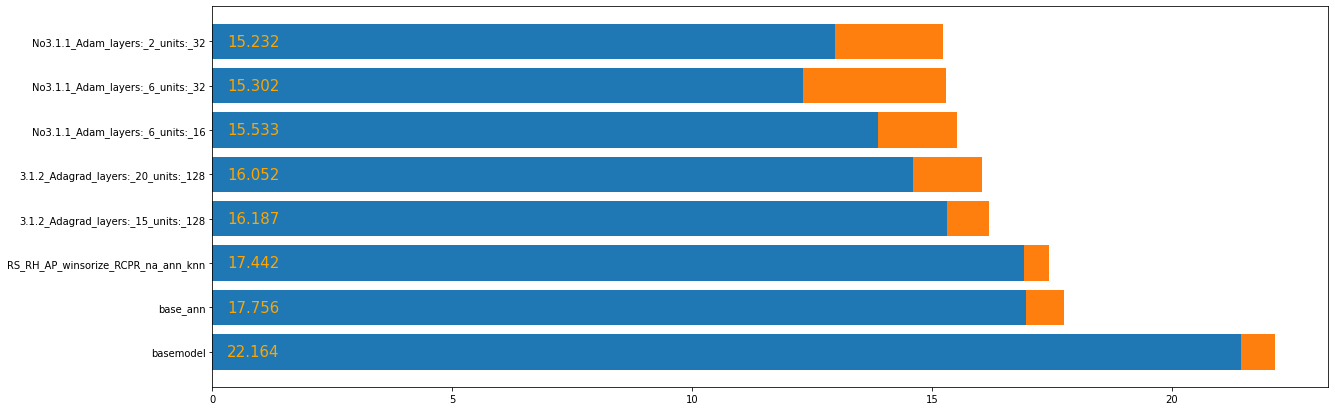

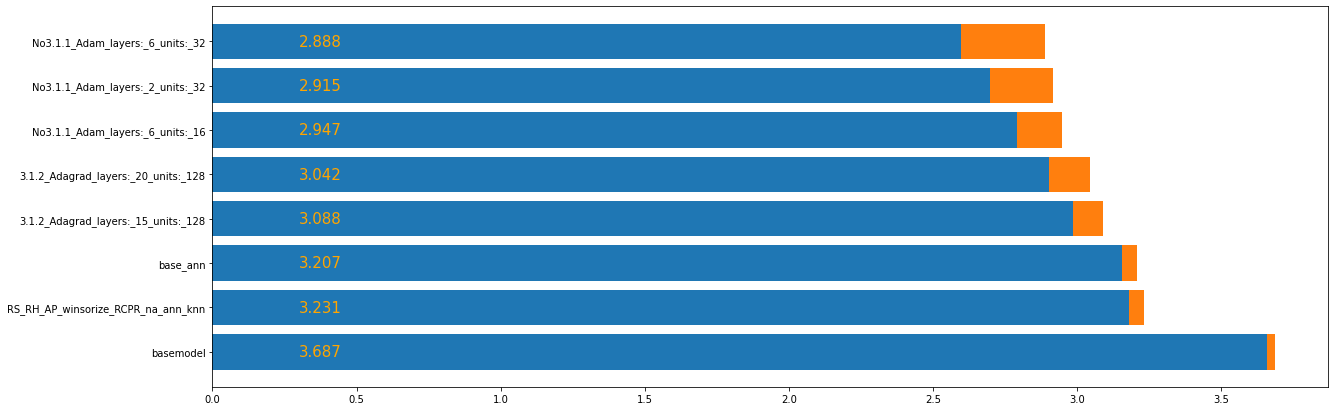

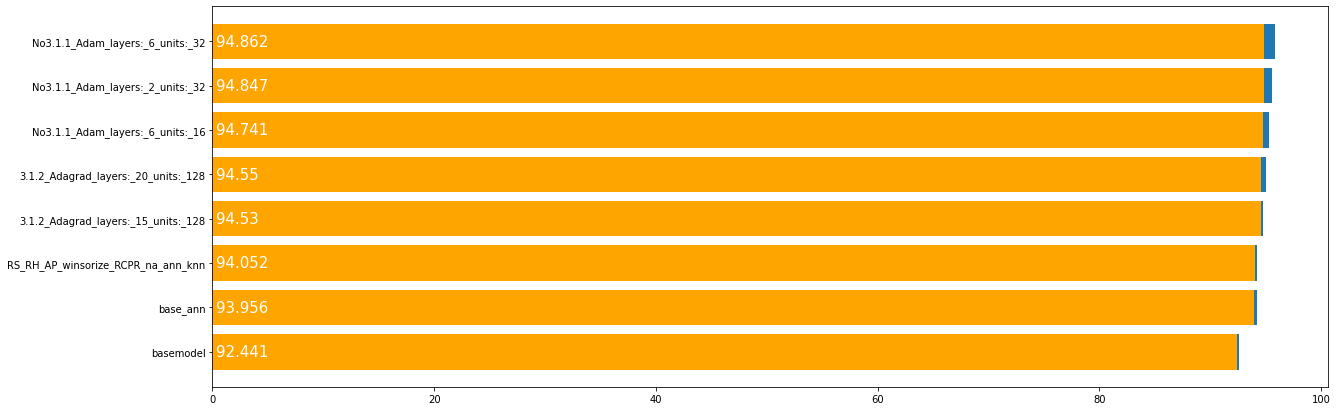

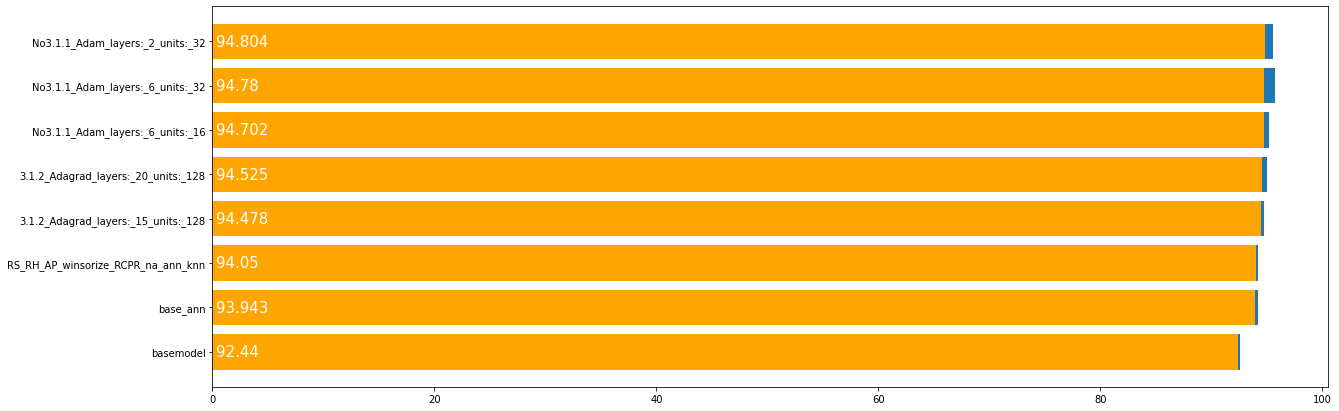

In [ ]:
update_results(True)
show_results()

As there was problem in GitHub (msg: unable to render rich display) file was splitted and the rest of optimizers with conclusion can be found in 4_2_4_PipelineDataPreprocessing_DL-ANN_Project_CPP_SGD_RMSProp_Results